# ***I. ICC Data Cleaning and Preprocessing***

This notebook is for ICC data preprocessing before training bayesian network.

Variables and values determined in an expert interview:

1.  **age at beginning medication**: <16, 16-24, 24-60, >60
    * calculate age first visit - birthyear. divide categories
2.  **gender**: male, female
3.  **disease location at diagnosis**: ileum, colon, both
      *  D_MON_LOC_CD. 1, 2, 3, 4, 5, 6.
      * ileum = 1, 4 colon: 2, 6 both: 3, 5
    
4. **disease location at inclusion**: ileum, colon, both
    * W1_MON_LOC_CD_INC. 1, 2, 3, 4, 5, 6. 
    * ileum = 1, 4 colon: 2, 6 both: 3, 5
5. **disease behavior at diagnosis**: inflammatory, stricturing, penetrating
    * D_MON_BEH_CD. 1, 2, 3
    * inflammatory: 1, stricturing: 2, penetrating: 3
6. **disease behavior at inclusion**: inflammatory, stricturing, penetrating
    * W1_MON_BEH_CD_INC. 1, 2, 3
    * inflammatory: 1, stricturing: 2, penetrating: 3
7.  **previous medication**: prednison (corticosteroid), mesalazines (5-ASA), thiopurines, immunomodulators,

8.  **anti-TNF** (infliximab, adalimumab, golimumab, certolizumab pegol), anti-leucine 12, anti-interkines, jak-inkibiteren
    * medication history available. check the medications
    * MH_BUD, MH_CORT, MH_5_ASA, MH_THIO, MH_TGN, MH_MTX, MH_IFX, MH_ADA, MH_GOL, MH_CERT, MH_VEDO, MH_USTE, MH_TOFA, MH_O_BIO
    * MH_O_BIO_BIN, MH_O_IMM_BIN, MH_O_IMM

9. **calpro**: <100, 100-250, >250
    * W1_LAB_CAL
10. **CRP**: <10, >10
    * W1_LAB_CRP
11.  **medical history**: cancer yes, cancer no
        * different cancer info available. No other medical history. 
        * Ever cancer: CM_C_CRC, CM_C_L, CM_C_BR, CM_C_NHL, CM_C_NMSC, CM_C_MSC, CM_C_P, CM_C_CX, CM_C_O
13. **smoking**: never, past, current
    * at inclusion W1_SMOK 1: never, 2: past, 3: current
14. **prior surgery**: yes, no
    * surgeries: MH_CD_PERIAN_SUR, W1_FISTELOK
15. **BMI** (length and weigth): <18.5, 18.5-24.9, 25.0-29.9, >30.0
    * calculate using: W1_HEIGHT, W1_WEIGHT
16. **thrombocytes**: ranges to be determined..
    * W1_LAB_TB
17. **number of comorbidities**: 0, 1, 2, 3....
    * columns indicating presence of a specific comorbidity
    * CM_M_DM, CM_M_HCHOL, CM_IN_HIV, CM_IN_HV, CM_NEU_EP, CM_NEU_MIG, CM_NEU_PAR, CM_HEAR, CM_VIS, CM_CV_AH,
    * CM_CV_CVA, CM_CV_HEARTC, CM_CV_HEARTD, CM_CV_HEARTR, CM_CV_HEARTV, CM_LUNG_ASTMA, CM_LUNG_COPD, CM_SKIN_PS, CM_SKIN_E, 
    * CM_RI, CM_ALC_LIV, CM_ALC_O, CM_LM_RA, CM_LM_SPA, CM_LM_OP, CM_LM_PA, CM_LM_CB, CM_IM_C, CM_IM_O, CM_PSY_MR, CM_PSY_DEM,
    * CM_PSY_DR, CM_PSY_ALC, CM_PSY_DEP, CM_PSY_A, CM_PSY_ASS, CM_PSY_ADHD, CM_PSY_B, CM_PSY_P, CM_PSY_BO
18. **disease duration** (in years): <2, 2-5, >5
    * from diagnosis until first visit date
19. **age at diagnosis**: <16, 16-24, 24-60, >60
    * calculate birthyear and diagnosis date D_DATE
20. **apendectomy**: yes, no
    * MH_AP_UC
21. **extraintestinal manifestations**: yes, no


variables used in DEDUCE: age, HBI at baseline, steroids at baseline, treatmetn, prior surgery, CRP, disease duration.

disease behavior, current smoker, gender, number of prior TNFs. These were selcted by RFE algorithms (LR, RF, SVM, XgBoost)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import date
import re
import seaborn as sns
from scipy import stats

## 1. Read raw data

In [2]:
# 1. Read raw data
icc_raw = pd.read_excel("ICC_CD.xlsx")

## 2. Handle null and placeholder values

In [3]:
# create dataframe for clean icc data
icc_clean = pd.DataFrame(icc_raw)

# 2. Handle null and placeholder values
null_values = ['#NULL!', '99', 99]
icc_clean.replace(null_values, np.nan, inplace=True)

# Remove columns with all null values
null_columns  = icc_clean.columns[icc_clean.isnull().all()]
icc_clean.drop(columns=null_columns, inplace=True)

<ipython-input-3-4537664bd90d>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  icc_clean.replace(null_values, np.nan, inplace=True)


## 3. Exclude irrelevant visit columns and specific columns

In [4]:
# 3. Exclude irrelevant visit columns and specific columns

# exclude columns W2, W3, W5, W6 . Because they are not relevant for this analysis. 
# Predictor variables are on W1 or before (D) and outcome on W4
# exclude other columns: D_FIRSTFISTEL_DATE

visit_cols = [col for col in icc_clean.columns if any(w in col for w in ['W2', 'W3', 'W5', 'W6', 'WE6'])]
exclude_cols = visit_cols + ['D_FIRSTFISTEL_DATE']
icc_clean.drop(columns=exclude_cols, inplace=True)

##  4. Date preprocessing with robust error handling

In [5]:
def clean_dates(df):
    # Specific error corrections
    date_corrections = {
        14540: {'W4_PLANVISDAT': '2019-08-28'},
        17783: {'D_DATE': np.nan}
        }
    for respnr, corrections in date_corrections.items():
        for col, value in corrections.items():
            df.loc[df['RESPNR'] == respnr, col] = pd.to_datetime(value)
    # Convert date columns
    date_cols = df.select_dtypes(include=['object']).columns
    for col in date_cols:
        if 'DAT' in col:
            df[col] = pd.to_datetime(df[col], errors='coerce')
                
    # Remove future dates
    today = pd.to_datetime(date.today())
    date_columns = df.select_dtypes(include=['datetime64']).columns
    for col in date_columns:
        df.loc[df[col] > today, col] = np.nan
            
    return df
    
icc_clean = clean_dates(icc_clean)

## 5. Numeric conversion with advanced cleaning

In [6]:
def clean_and_convert(value):
    """
    Robust numeric conversion function
    - Removes non-numeric characters
    - Handles comma and period as decimal separators
    - Converts to float with error handling
    """
    if pd.isna(value):
        return np.nan
        
    # Remove non-numeric characters except periods and commas
    cleaned = re.sub(r'[^\d.,]', '', str(value))
        
    # Replace comma with period for decimal
    cleaned = cleaned.replace(',', '.')
        
    try:
        return float(cleaned)
    except ValueError:
        return np.nan
    
# Apply to specific columns
numeric_cols = ['W1_LAB_CRP', 'W4_LAB_CRP', 'W1_LAB_CAL', 'W4_LAB_CAL']
for col in numeric_cols:
    icc_clean[col] = icc_clean[col].apply(clean_and_convert)
    

## 6. Special case handling

In [7]:
# 6. Special case handling
# Correct specific data anomalies
special_cases = {
    18280: {'BIRTHYEAR': np.nan}
}
    
for respnr, corrections in special_cases.items():
    for col, value in corrections.items():
        icc_clean.loc[icc_clean['RESPNR'] == respnr, col] = value
    

## 7. Filter for specific medications

In [8]:
# 7. Filter for specific medications
target_medications = [180, 202, 290]  # Ustekinumab, Vedolizumab
icc_clean = icc_clean[icc_clean['MEDICINE'].isin(target_medications)]
    

## 8. Final data validation and cleaning

In [9]:
icc_clean.W1_HB_ARTHRITIS.sum()

0.0

In [10]:
# 8. Final data validation and cleaning
null_columns  = icc_clean.columns[icc_clean.isnull().all()]
icc_clean.drop(columns=null_columns, inplace=True)

icc_clean.reset_index(drop=True, inplace=True)

In [11]:
# Create output directory
import os
os.makedirs('icc_analysis', exist_ok=True)
#save the cleaned data To csv file
icc_clean.to_csv("icc_analysis/cleaned_icc_data.csv", index=False)

# ***II. ICC Data Analysis and Visualization***
Comprehensive analysis of ICC dataset with visualizations
    

Starting analysis...

Analyzing numeric variables...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


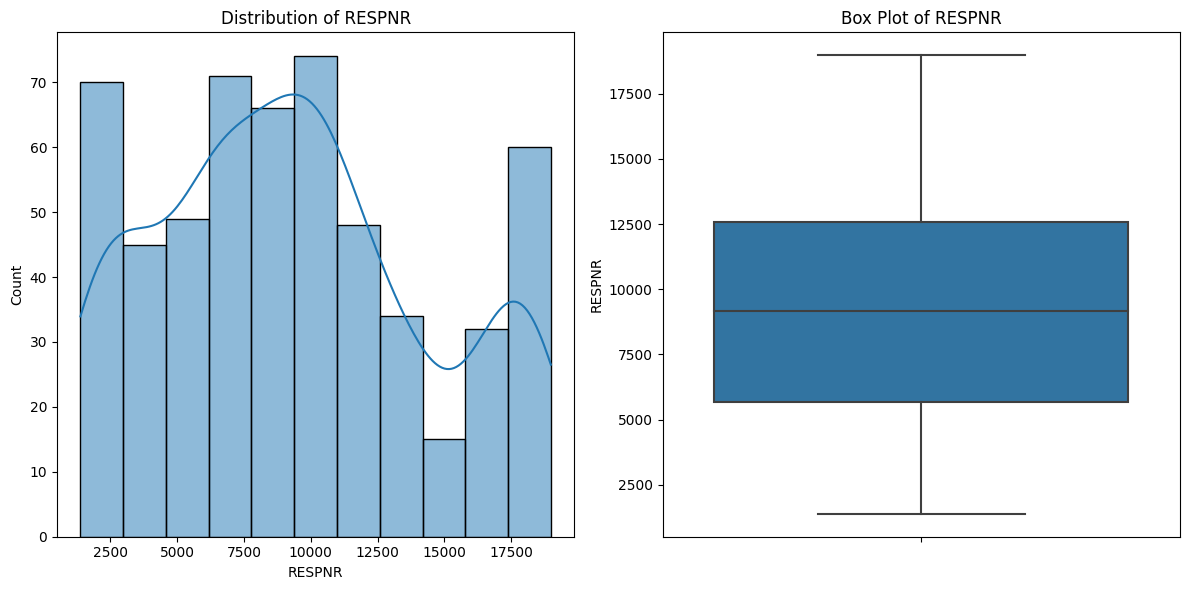


Statistics for RESPNR:
Count: 564
Missing: 0
Mean: 9324.28
Median: 9150.00
Std: 5030.62
Min: 1383
Max: 18980


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


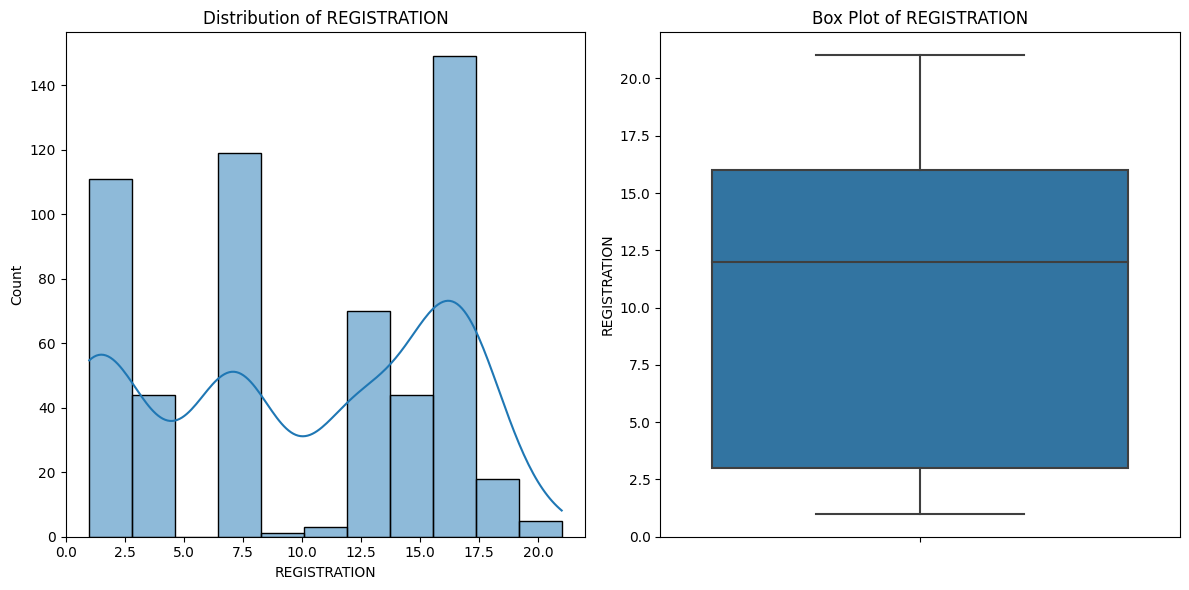


Statistics for REGISTRATION:
Count: 564
Missing: 0
Mean: 9.80
Median: 12.00
Std: 6.16
Min: 1.00
Max: 21.01


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


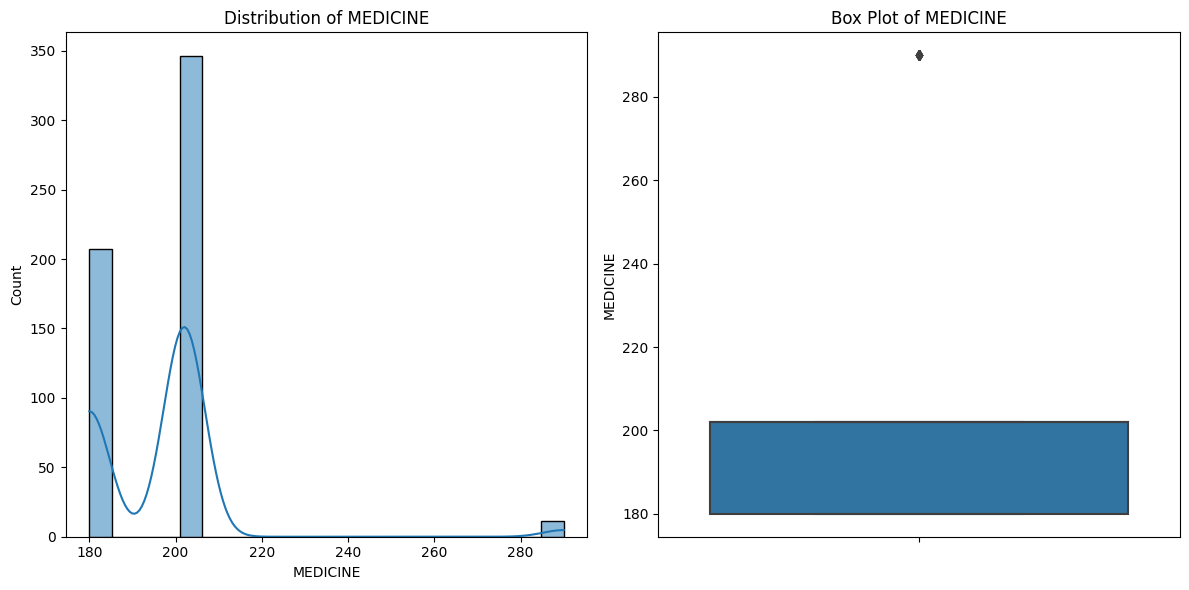


Statistics for MEDICINE:
Count: 564
Missing: 0
Mean: 195.64
Median: 202.00
Std: 16.99
Min: 180
Max: 290


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


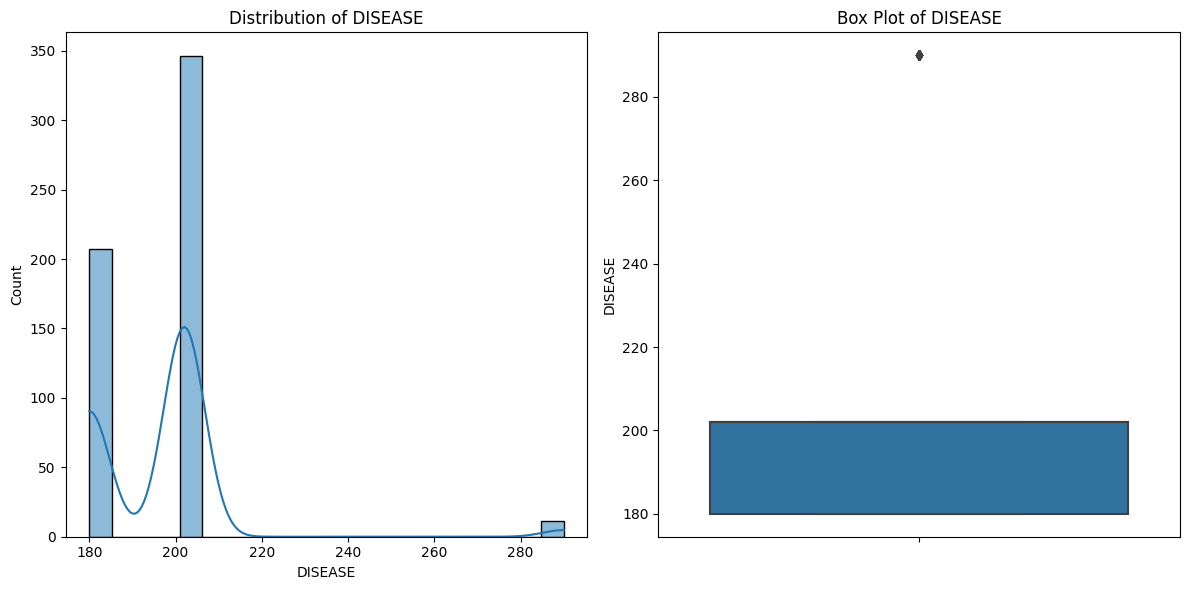


Statistics for DISEASE:
Count: 564
Missing: 0
Mean: 195.64
Median: 202.00
Std: 16.99
Min: 180
Max: 290


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


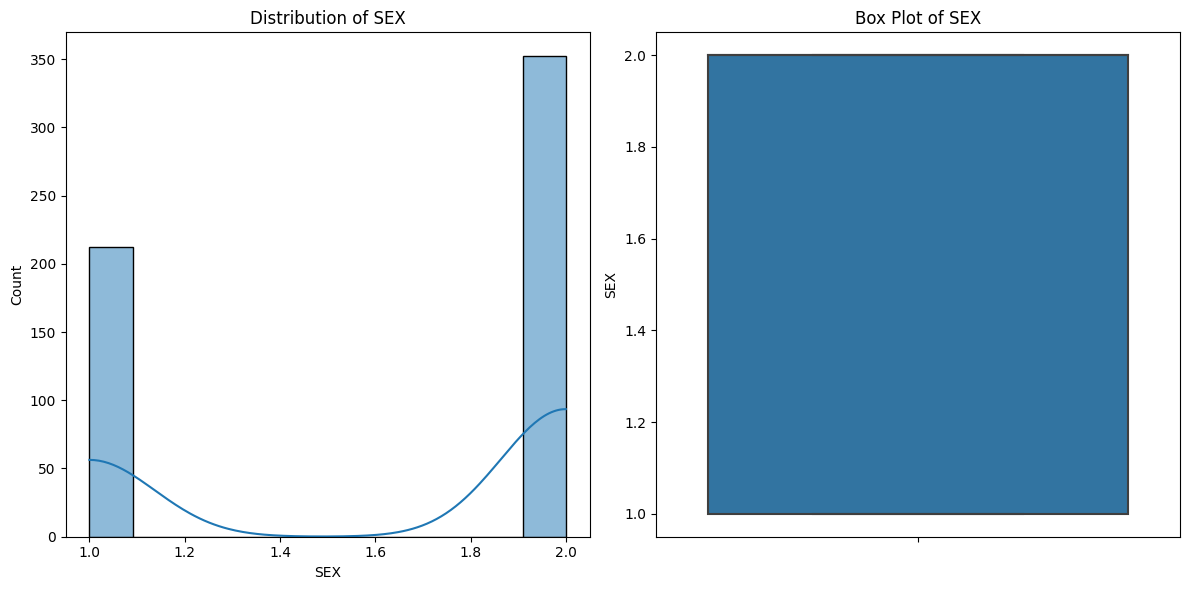


Statistics for SEX:
Count: 564
Missing: 0
Mean: 1.62
Median: 2.00
Std: 0.48
Min: 1
Max: 2


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


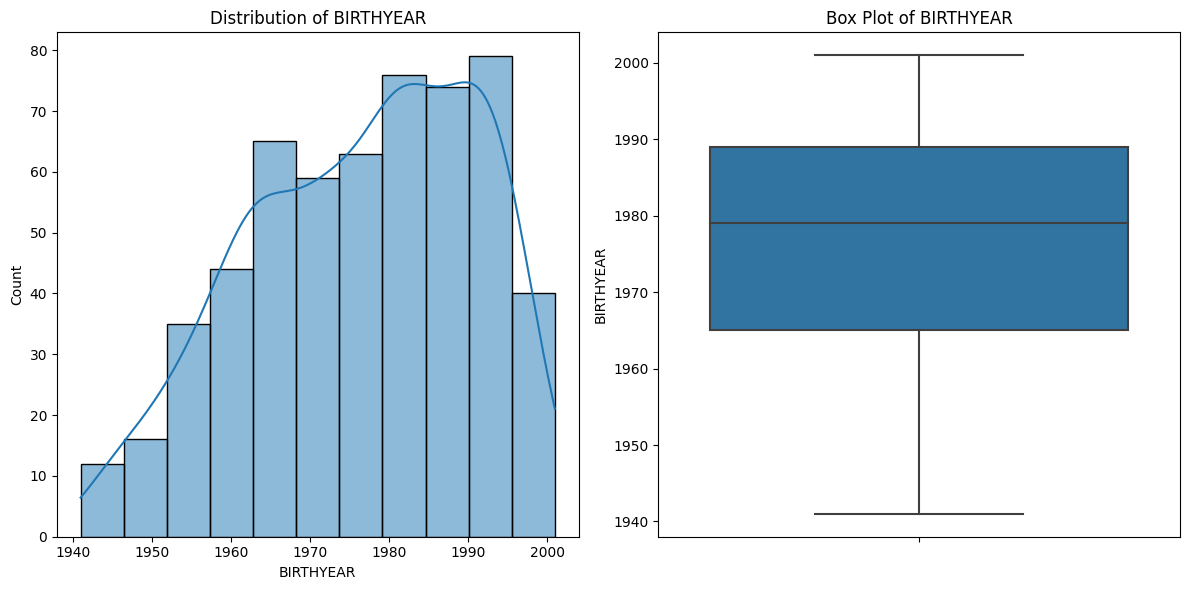


Statistics for BIRTHYEAR:
Count: 563
Missing: 1
Mean: 1976.48
Median: 1979.00
Std: 14.29
Min: 1941.00
Max: 2001.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


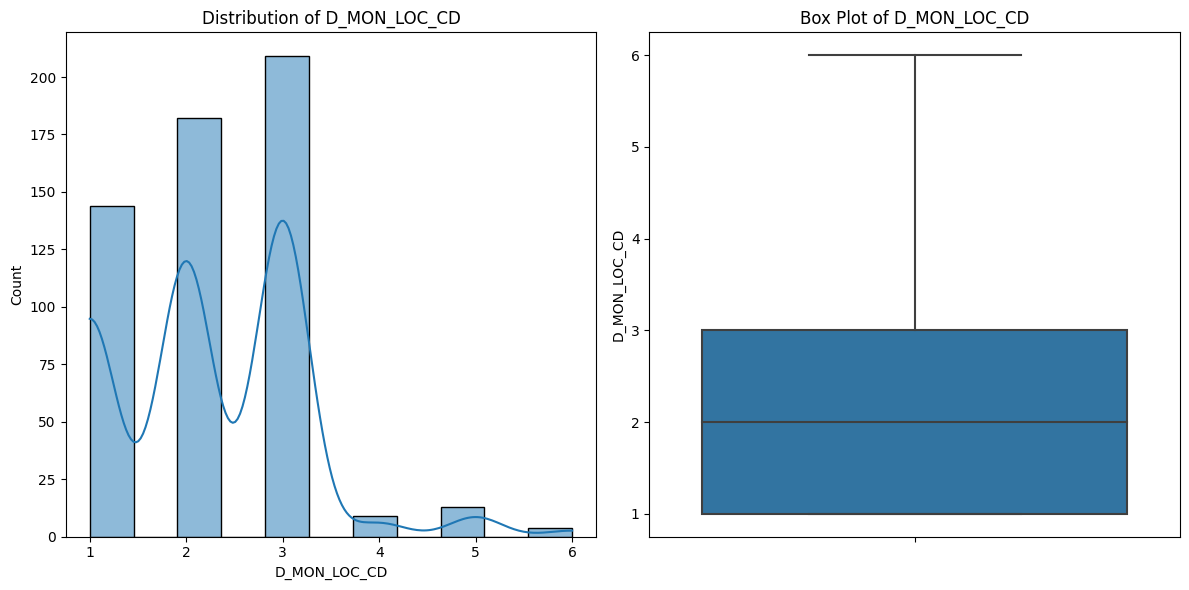


Statistics for D_MON_LOC_CD:
Count: 561
Missing: 3
Mean: 2.25
Median: 2.00
Std: 0.98
Min: 1.00
Max: 6.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


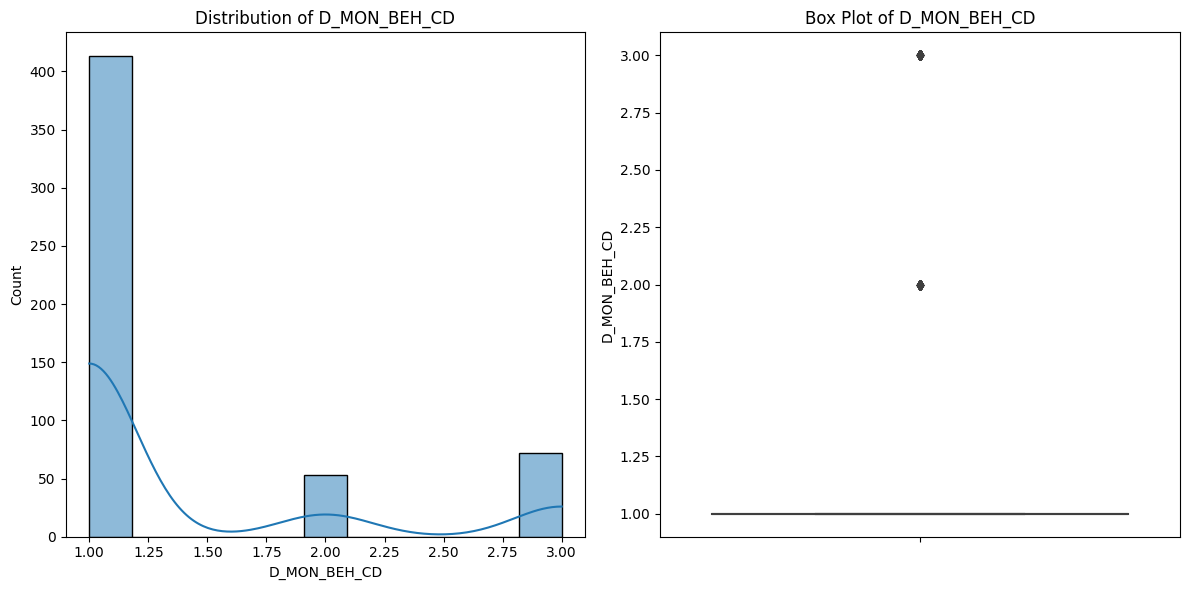


Statistics for D_MON_BEH_CD:
Count: 538
Missing: 26
Mean: 1.37
Median: 1.00
Std: 0.71
Min: 1.00
Max: 3.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


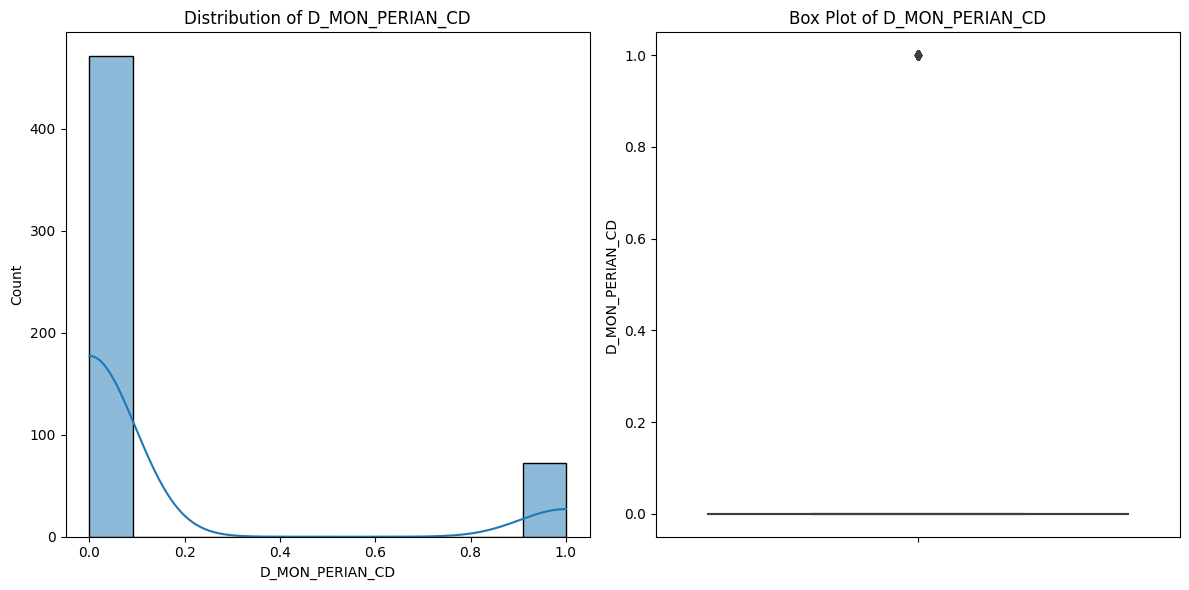


Statistics for D_MON_PERIAN_CD:
Count: 543
Missing: 21
Mean: 0.13
Median: 0.00
Std: 0.34
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


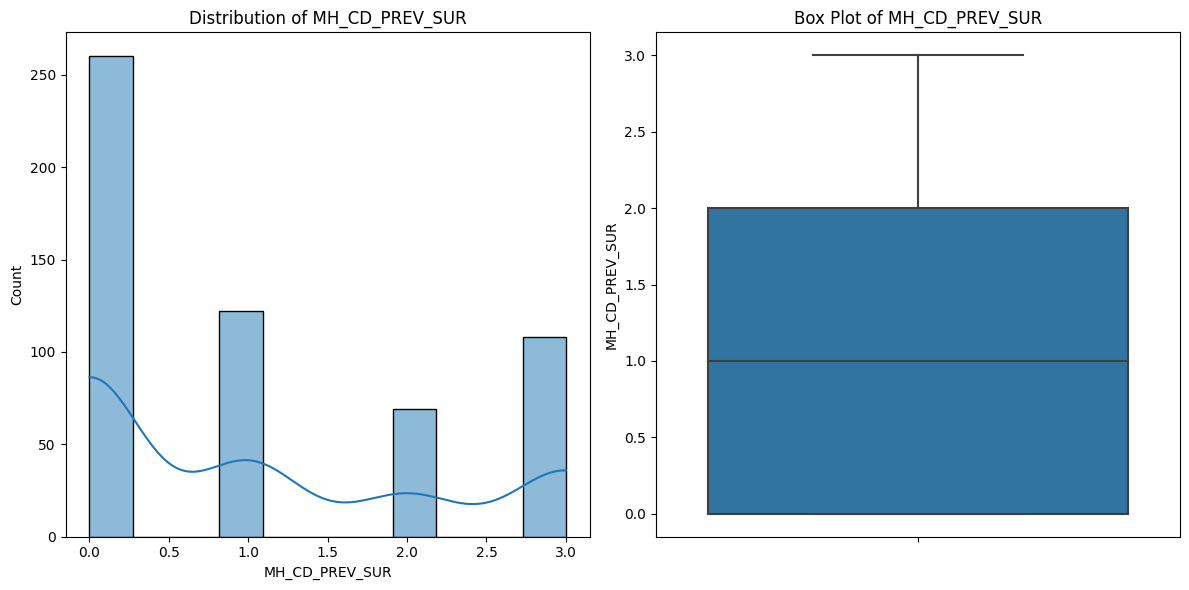


Statistics for MH_CD_PREV_SUR:
Count: 559
Missing: 5
Mean: 1.04
Median: 1.00
Std: 1.17
Min: 0.00
Max: 3.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


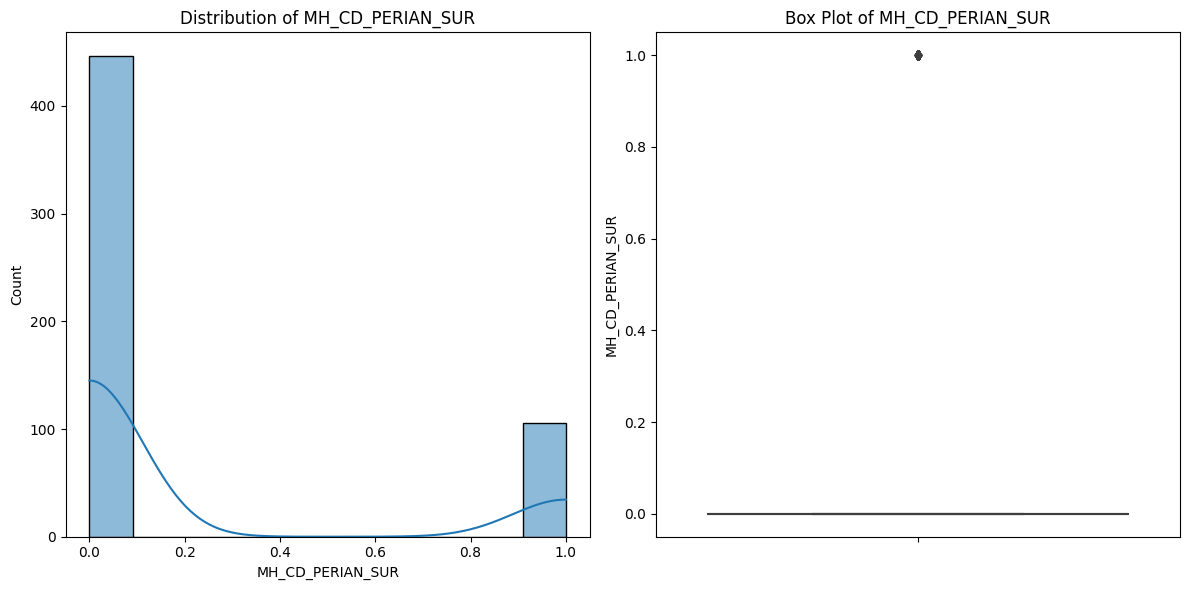


Statistics for MH_CD_PERIAN_SUR:
Count: 552
Missing: 12
Mean: 0.19
Median: 0.00
Std: 0.39
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


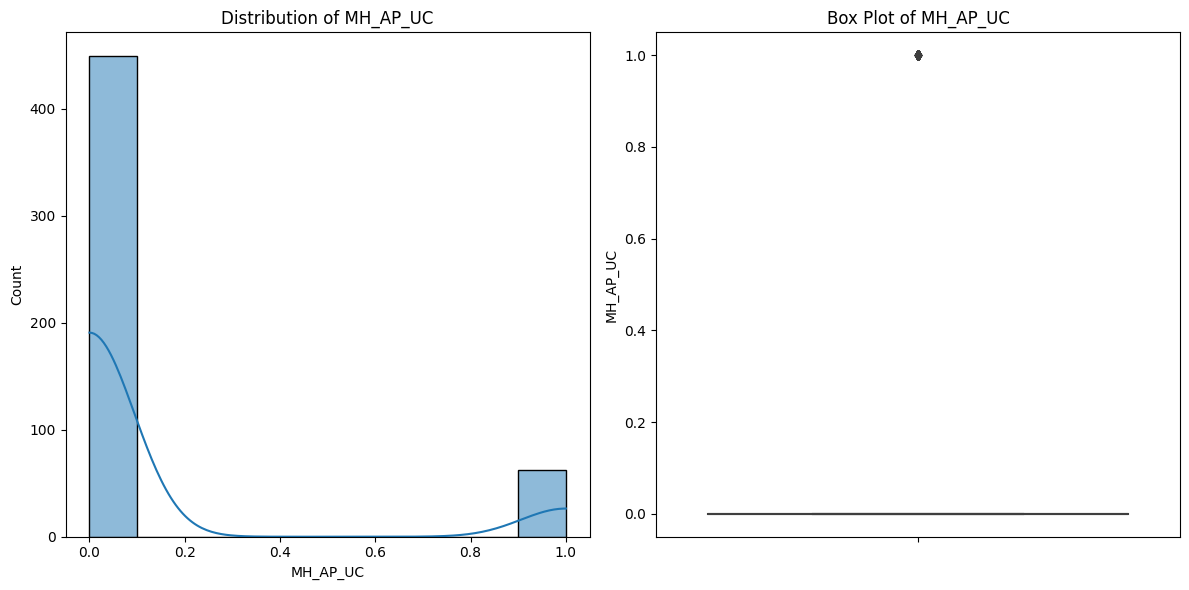


Statistics for MH_AP_UC:
Count: 511
Missing: 53
Mean: 0.12
Median: 0.00
Std: 0.33
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


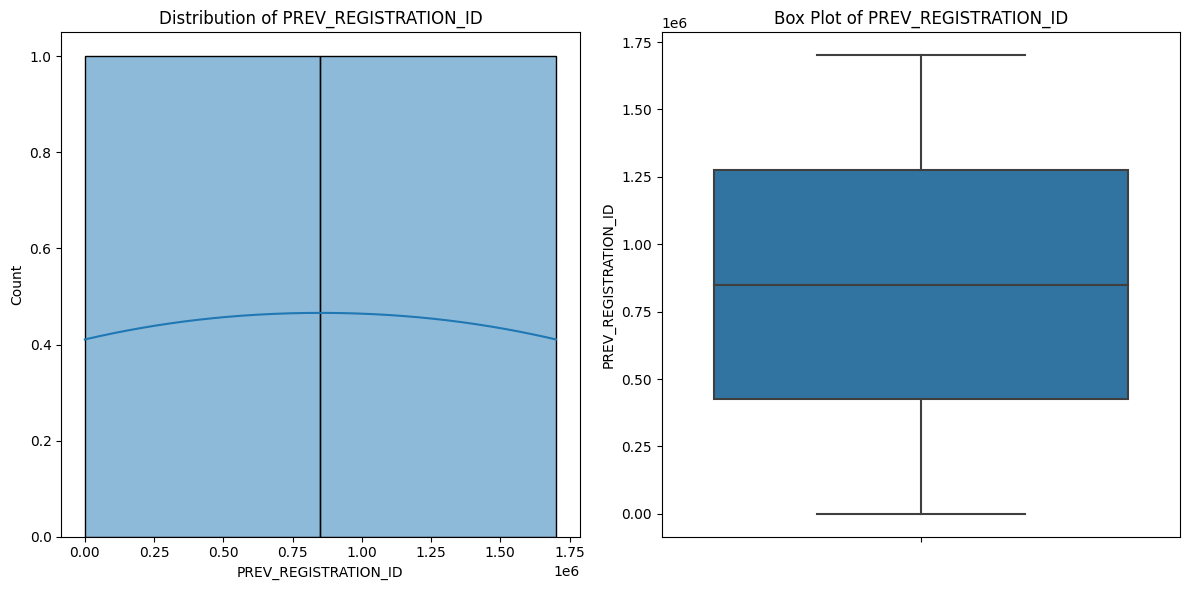


Statistics for PREV_REGISTRATION_ID:
Count: 2
Missing: 562
Mean: 850480.01
Median: 850480.01
Std: 1202743.37
Min: 12.01
Max: 1700948.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


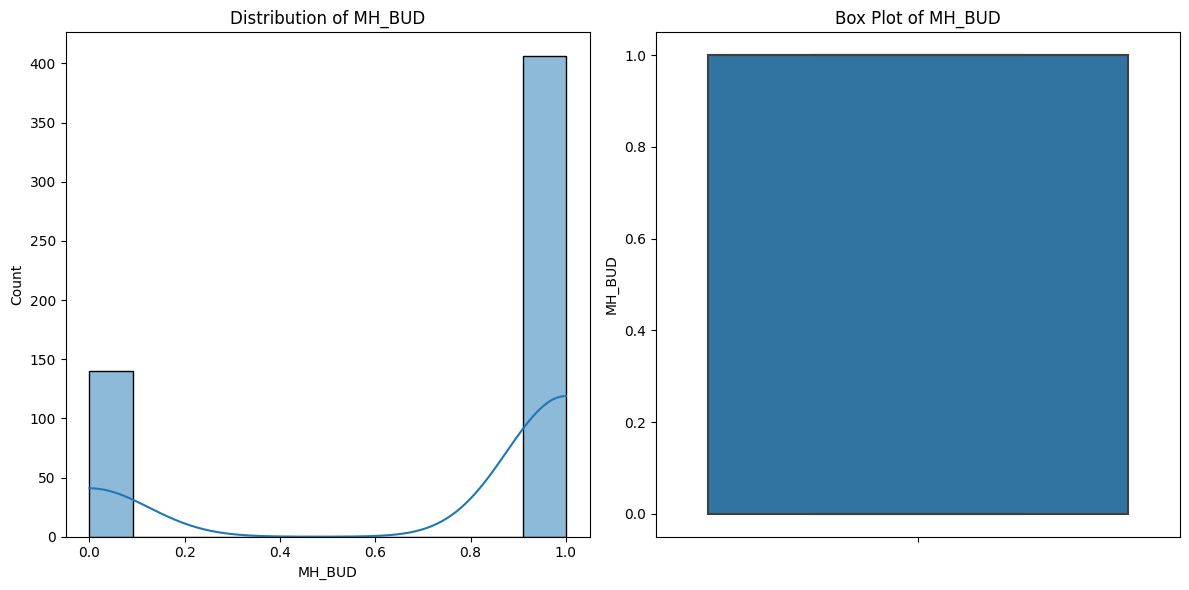


Statistics for MH_BUD:
Count: 546
Missing: 18
Mean: 0.74
Median: 1.00
Std: 0.44
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


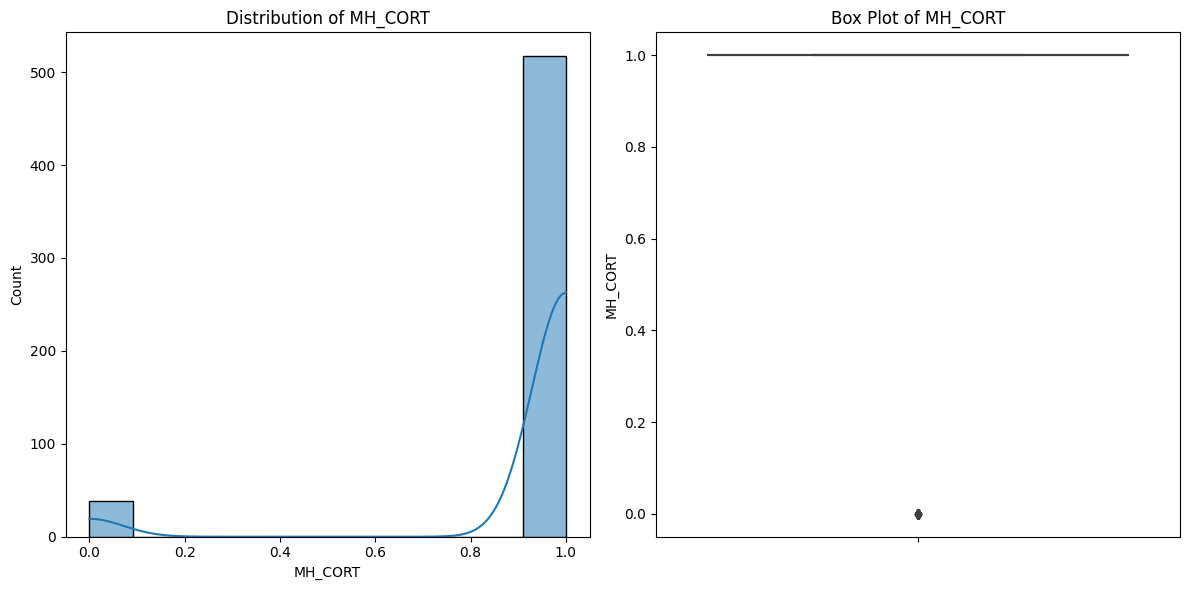


Statistics for MH_CORT:
Count: 555
Missing: 9
Mean: 0.93
Median: 1.00
Std: 0.25
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


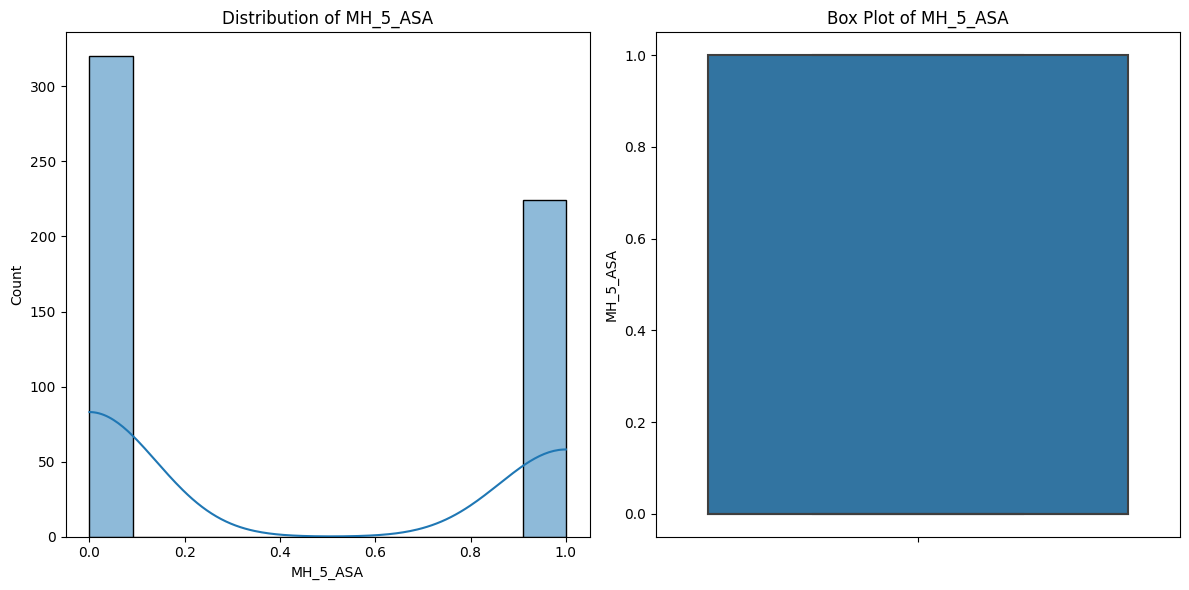


Statistics for MH_5_ASA:
Count: 544
Missing: 20
Mean: 0.41
Median: 0.00
Std: 0.49
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


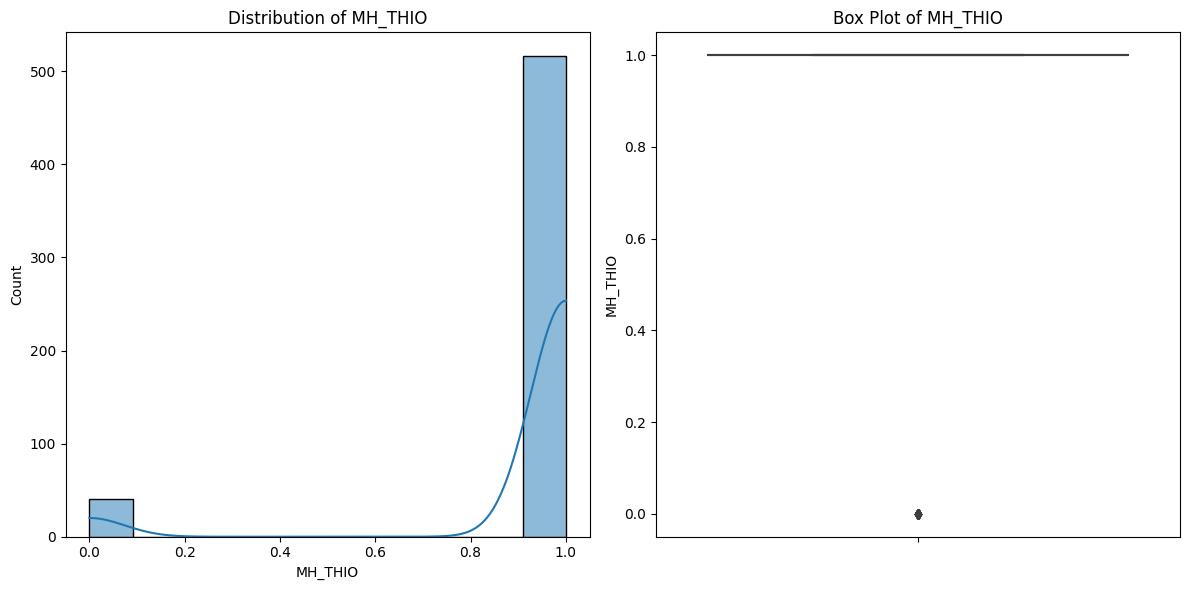


Statistics for MH_THIO:
Count: 557
Missing: 7
Mean: 0.93
Median: 1.00
Std: 0.26
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


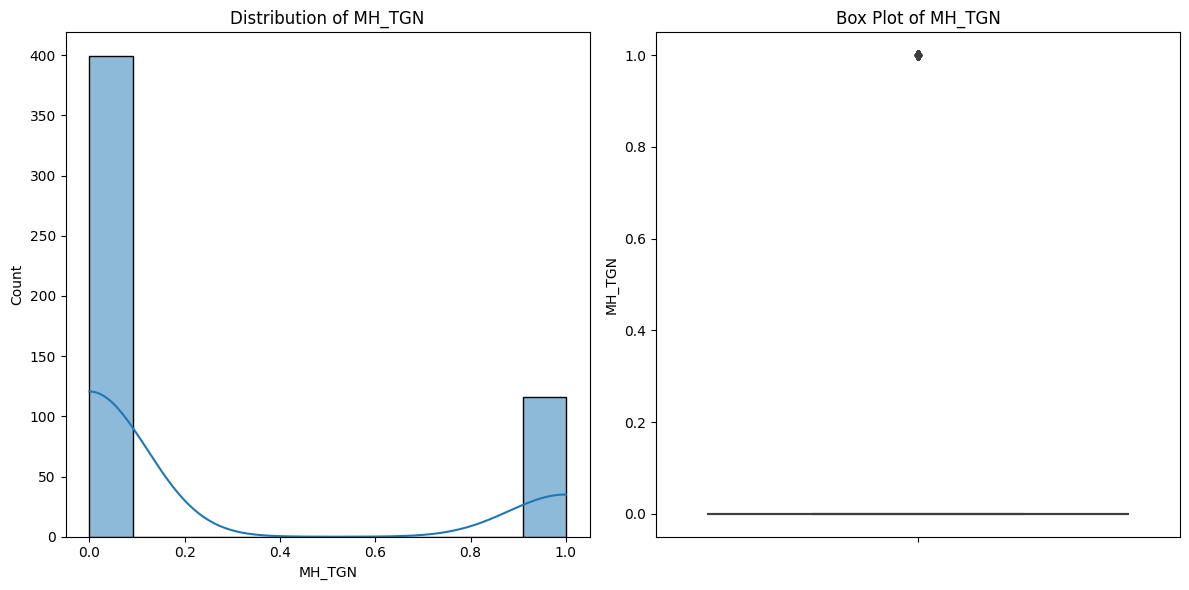


Statistics for MH_TGN:
Count: 515
Missing: 49
Mean: 0.23
Median: 0.00
Std: 0.42
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


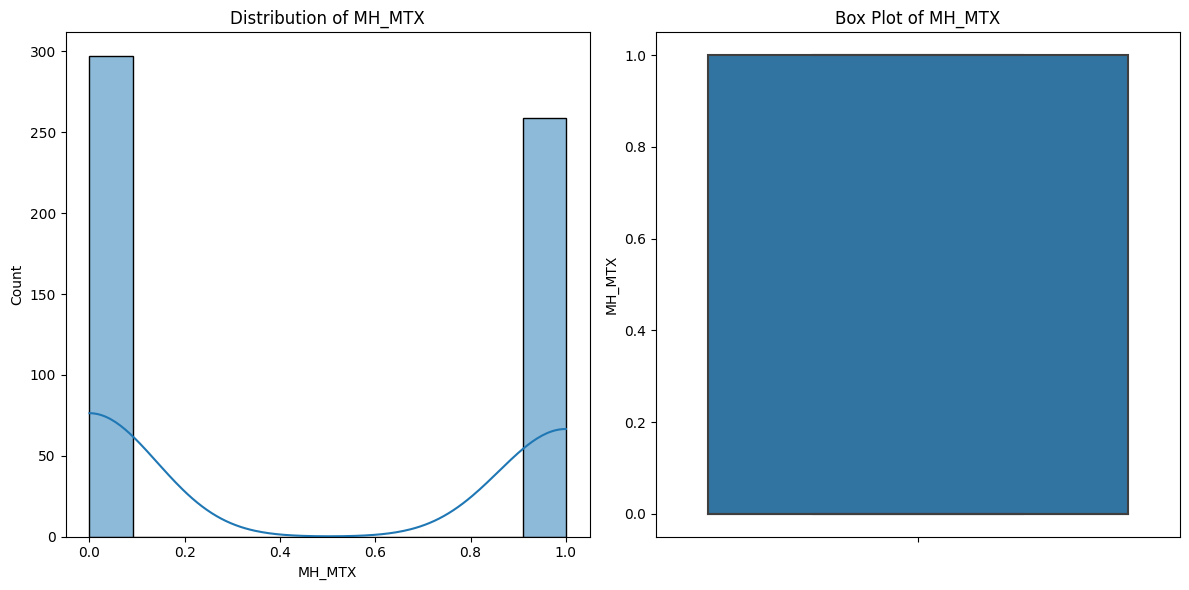


Statistics for MH_MTX:
Count: 556
Missing: 8
Mean: 0.47
Median: 0.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


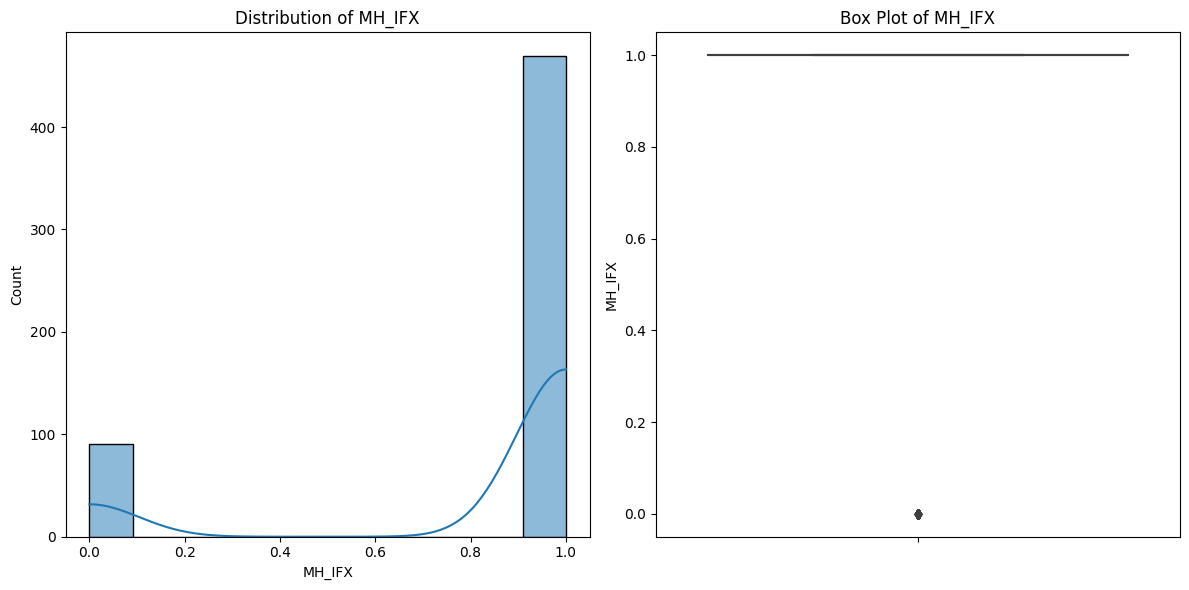


Statistics for MH_IFX:
Count: 560
Missing: 4
Mean: 0.84
Median: 1.00
Std: 0.37
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


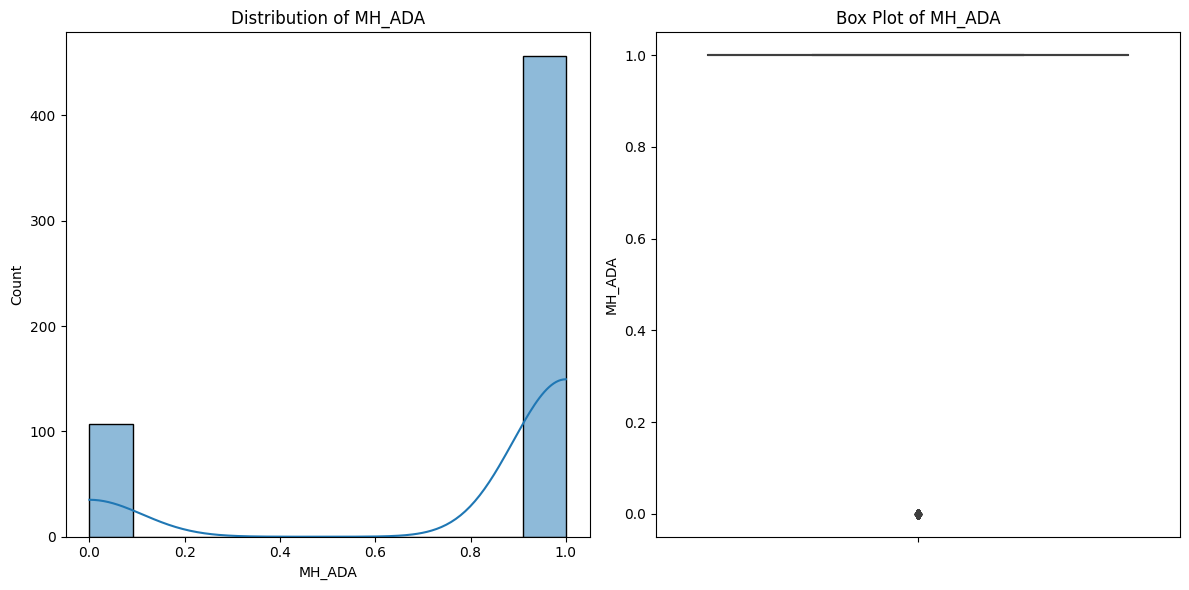


Statistics for MH_ADA:
Count: 563
Missing: 1
Mean: 0.81
Median: 1.00
Std: 0.39
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


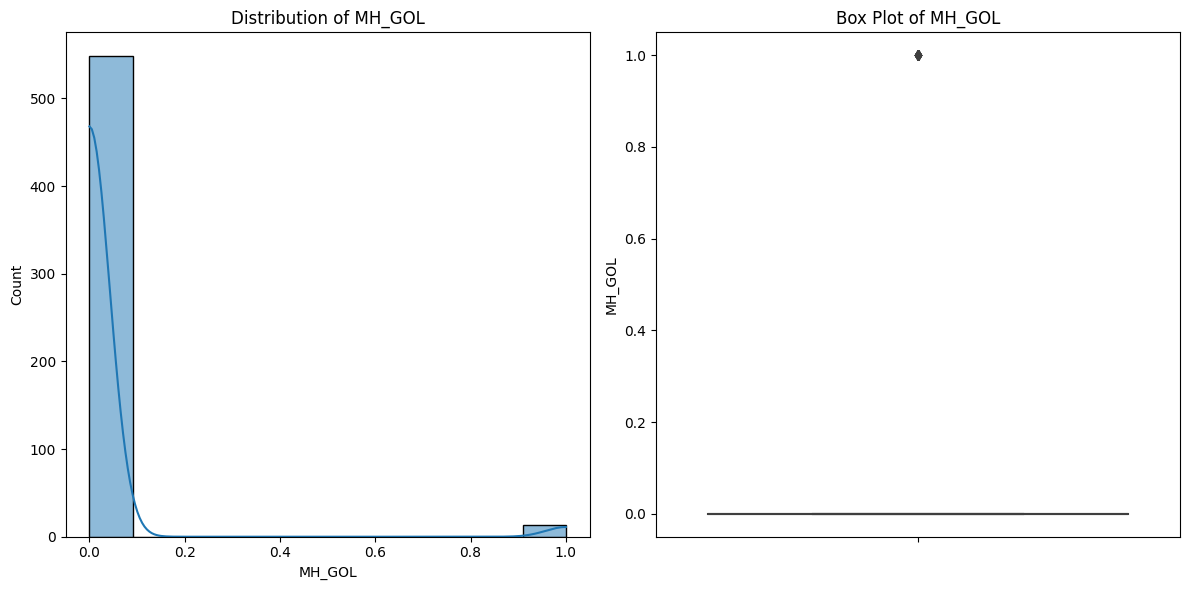


Statistics for MH_GOL:
Count: 561
Missing: 3
Mean: 0.02
Median: 0.00
Std: 0.15
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


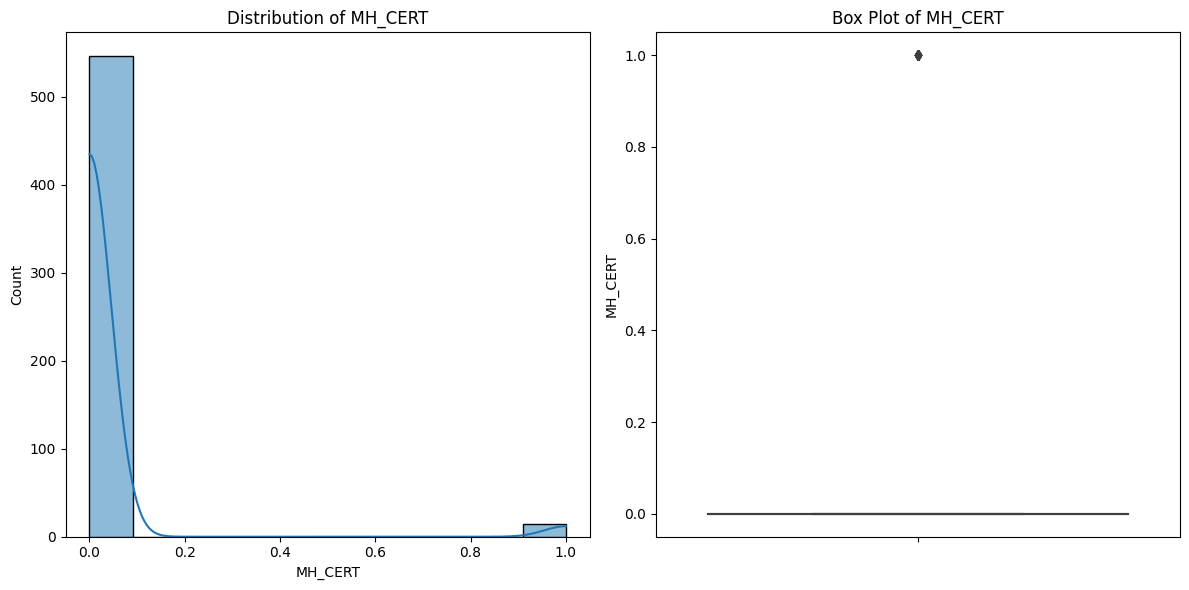


Statistics for MH_CERT:
Count: 561
Missing: 3
Mean: 0.03
Median: 0.00
Std: 0.16
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


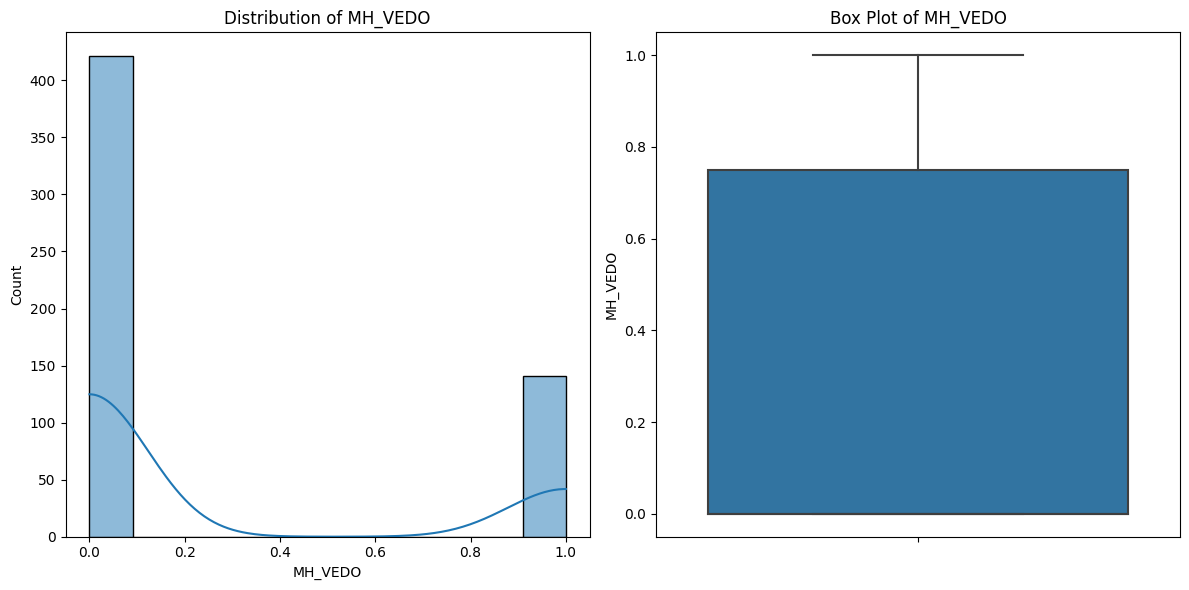


Statistics for MH_VEDO:
Count: 562
Missing: 2
Mean: 0.25
Median: 0.00
Std: 0.43
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


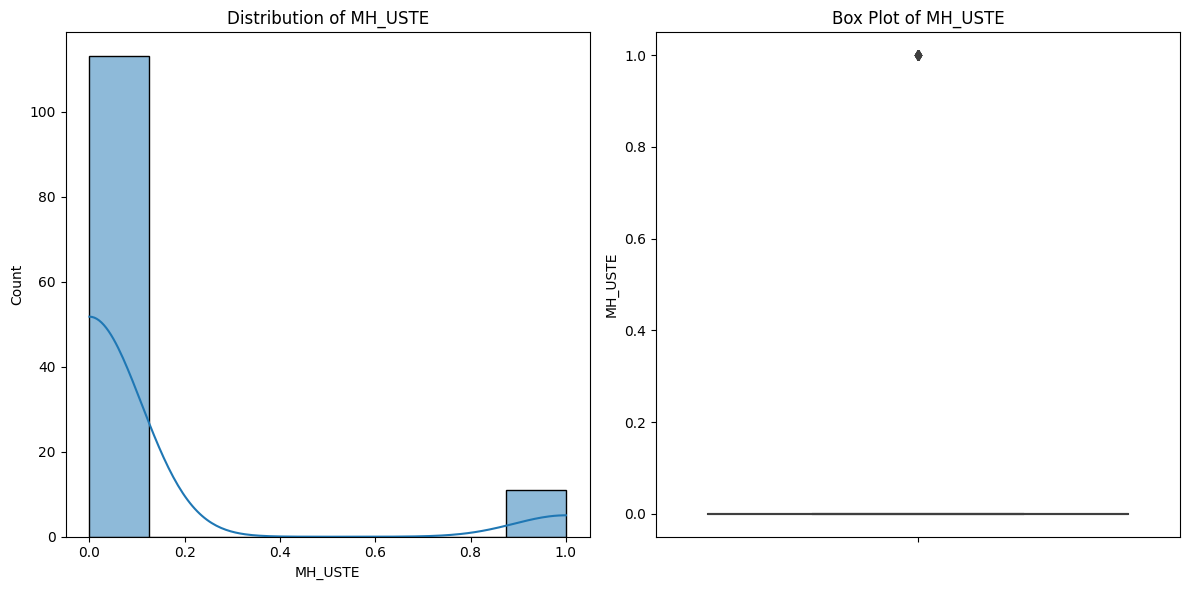


Statistics for MH_USTE:
Count: 124
Missing: 440
Mean: 0.09
Median: 0.00
Std: 0.29
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


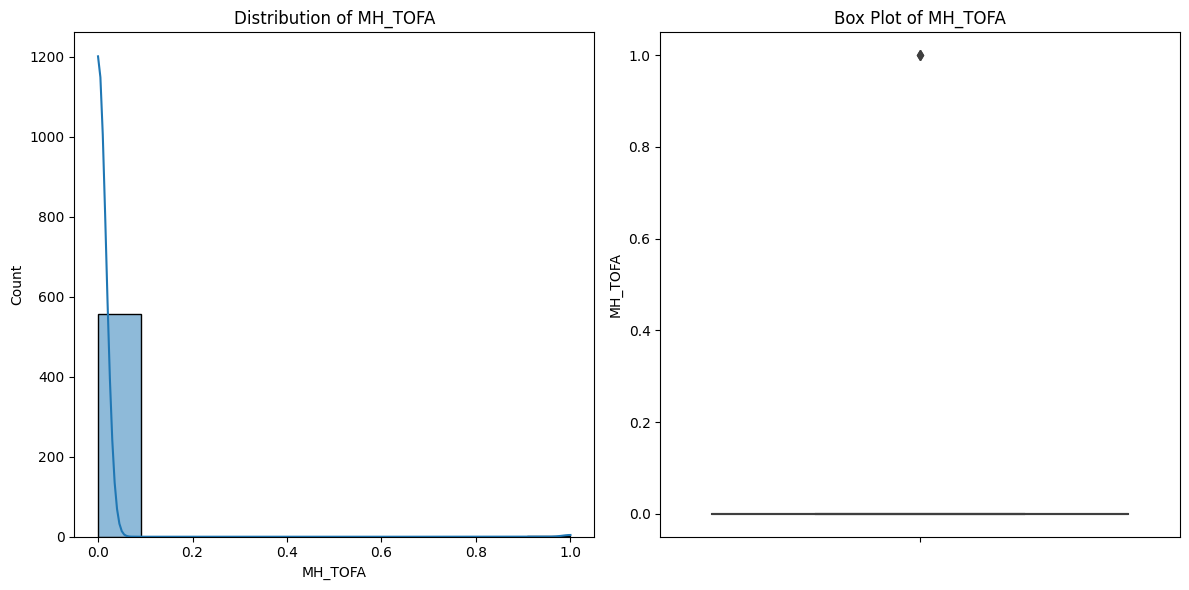


Statistics for MH_TOFA:
Count: 560
Missing: 4
Mean: 0.00
Median: 0.00
Std: 0.06
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


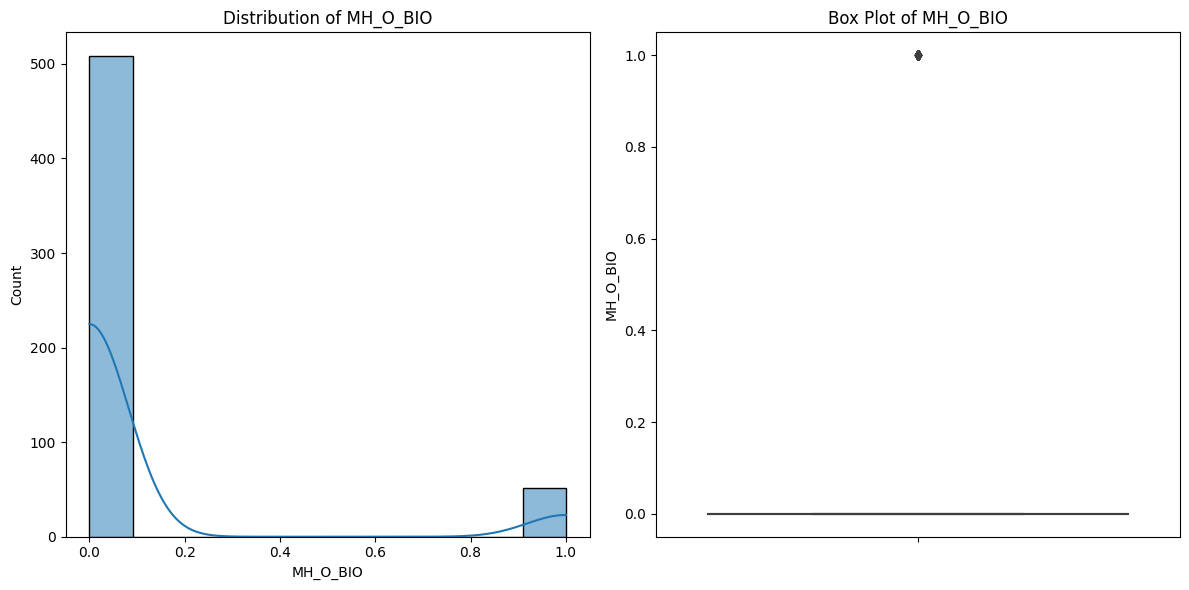


Statistics for MH_O_BIO:
Count: 560
Missing: 4
Mean: 0.09
Median: 0.00
Std: 0.29
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


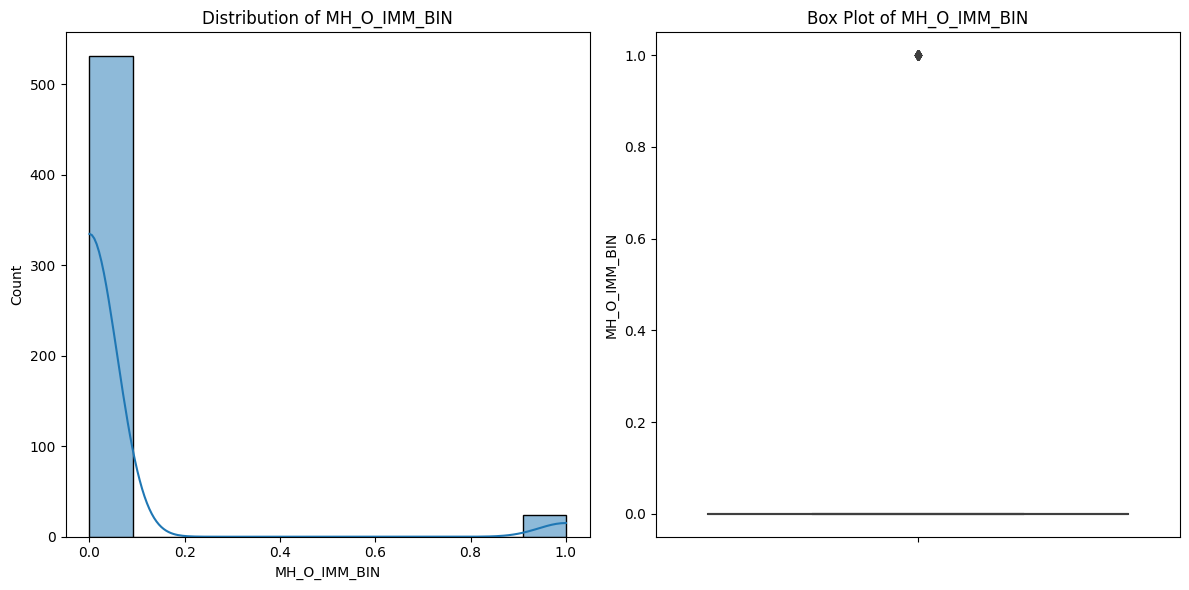


Statistics for MH_O_IMM_BIN:
Count: 555
Missing: 9
Mean: 0.04
Median: 0.00
Std: 0.20
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


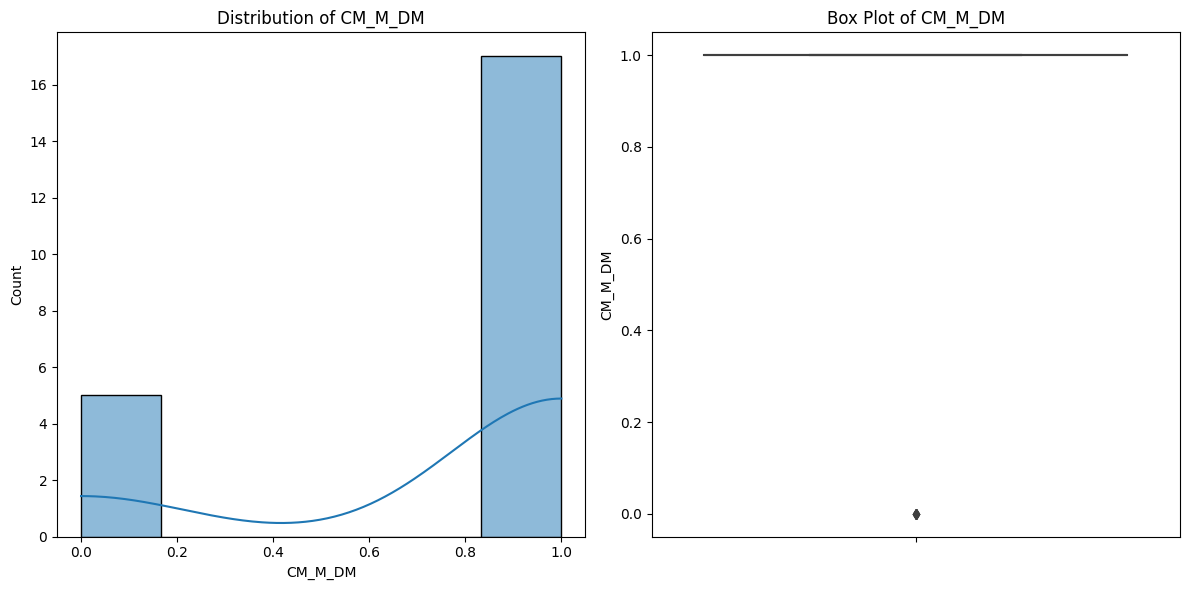


Statistics for CM_M_DM:
Count: 22
Missing: 542
Mean: 0.77
Median: 1.00
Std: 0.43
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


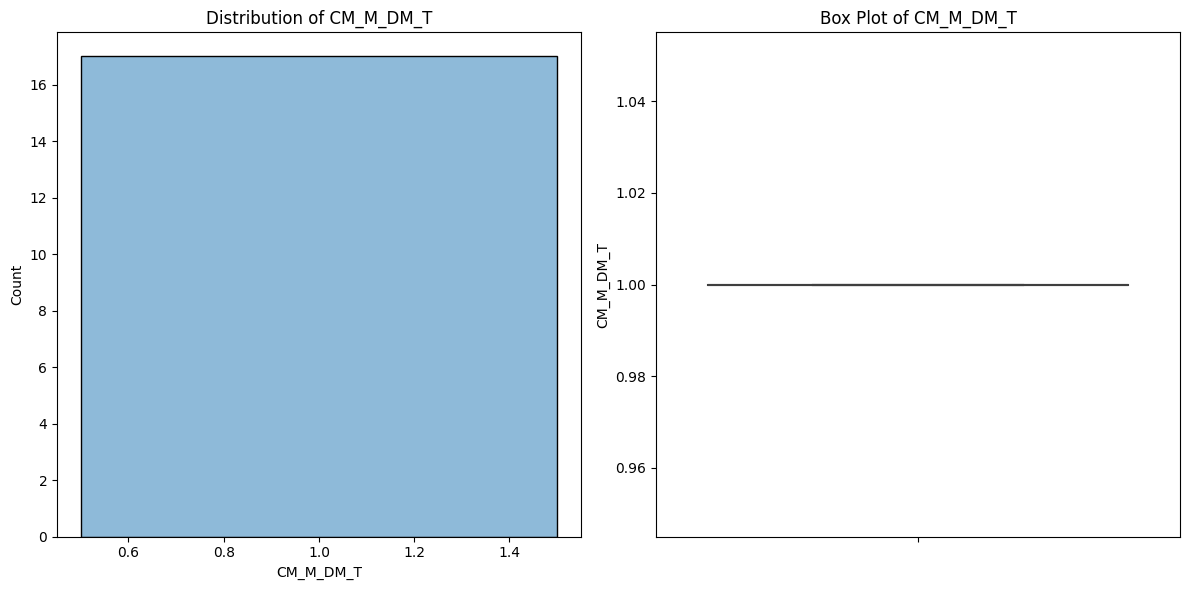


Statistics for CM_M_DM_T:
Count: 17
Missing: 547
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


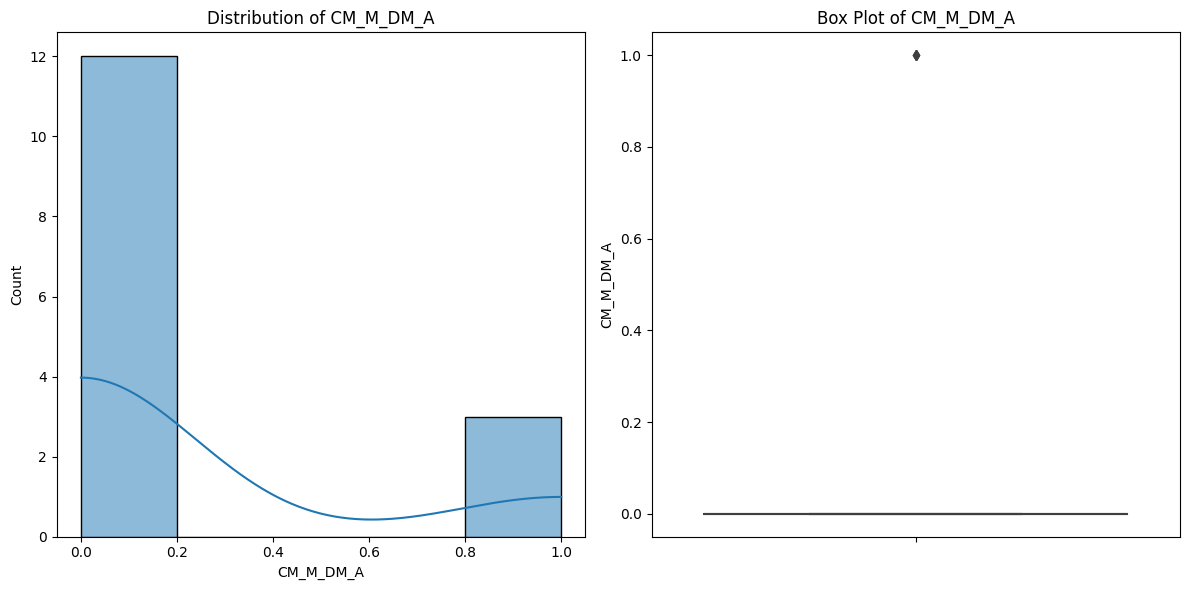


Statistics for CM_M_DM_A:
Count: 15
Missing: 549
Mean: 0.20
Median: 0.00
Std: 0.41
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


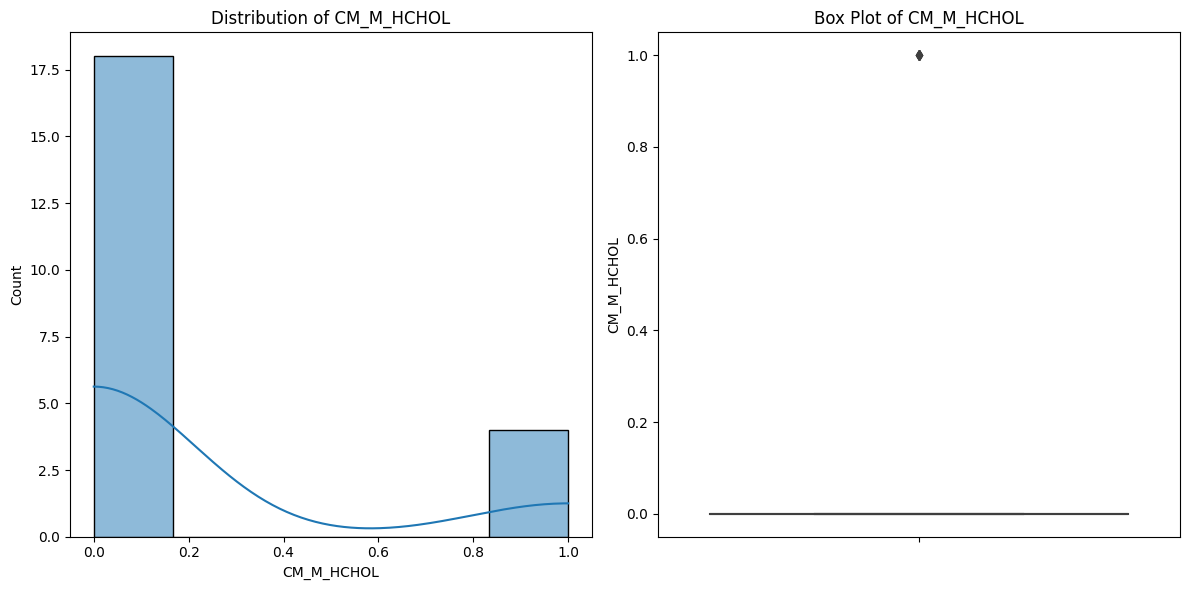


Statistics for CM_M_HCHOL:
Count: 22
Missing: 542
Mean: 0.18
Median: 0.00
Std: 0.39
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


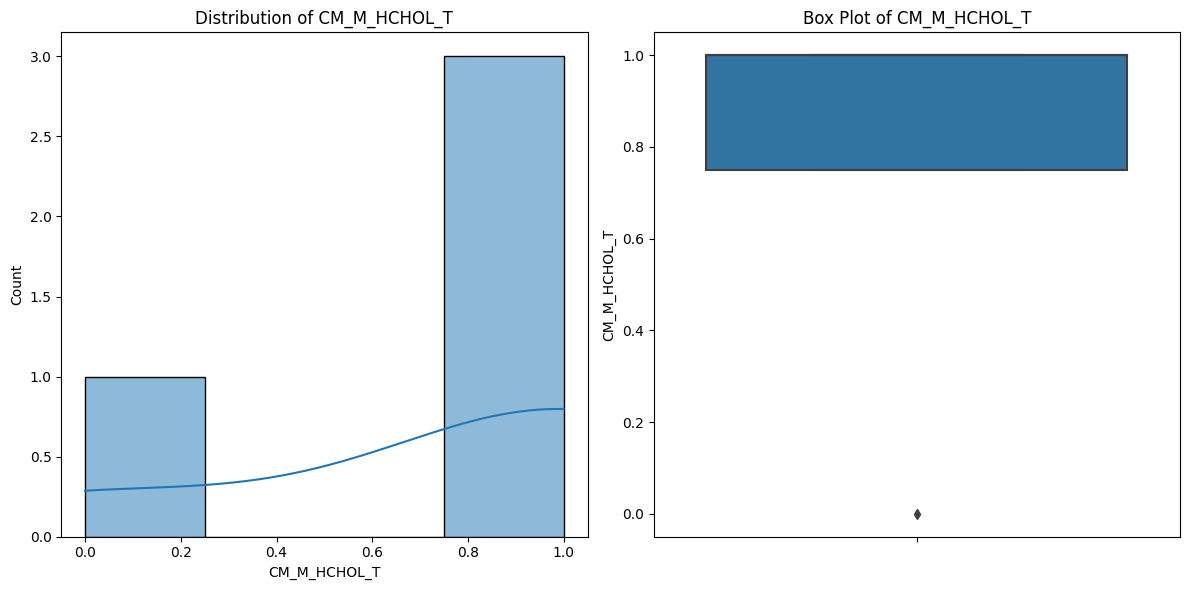


Statistics for CM_M_HCHOL_T:
Count: 4
Missing: 560
Mean: 0.75
Median: 1.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


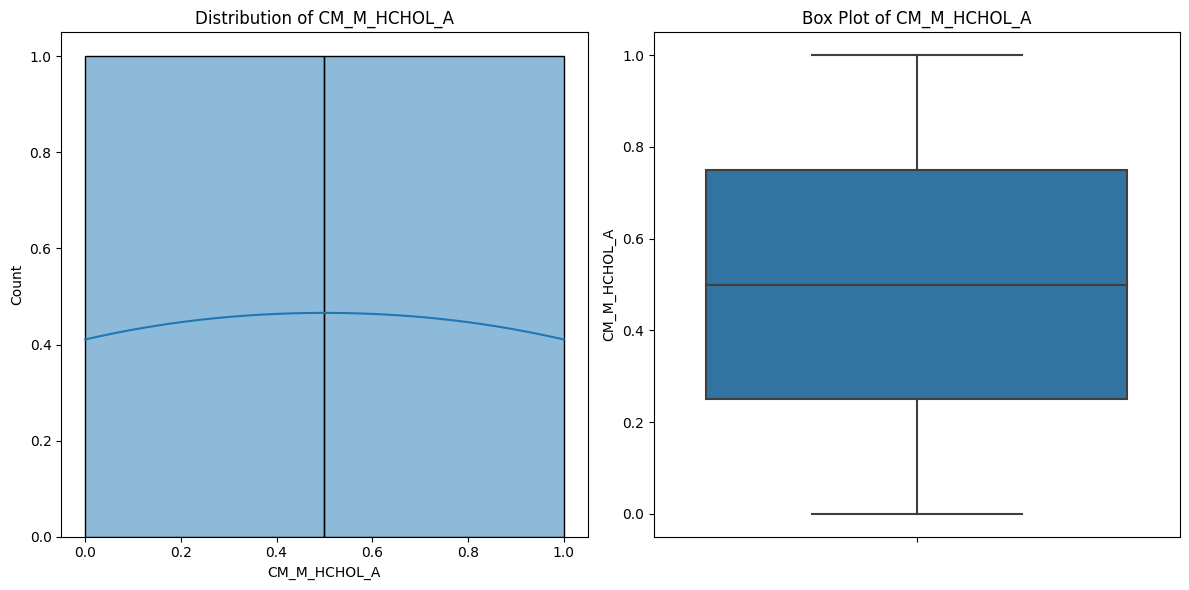


Statistics for CM_M_HCHOL_A:
Count: 2
Missing: 562
Mean: 0.50
Median: 0.50
Std: 0.71
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


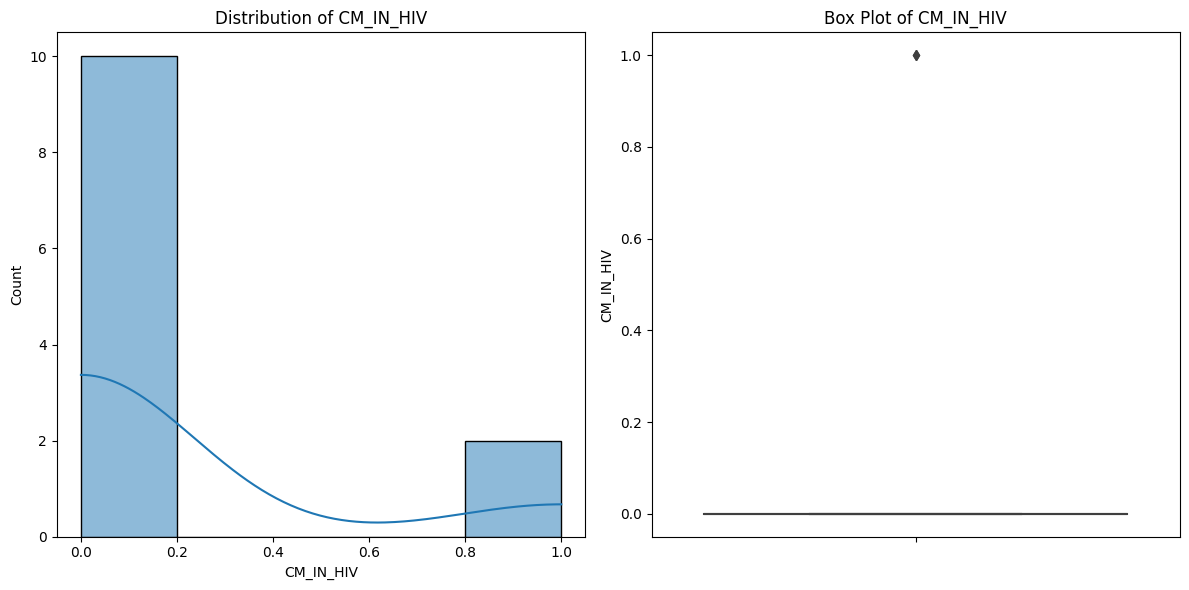


Statistics for CM_IN_HIV:
Count: 12
Missing: 552
Mean: 0.17
Median: 0.00
Std: 0.39
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


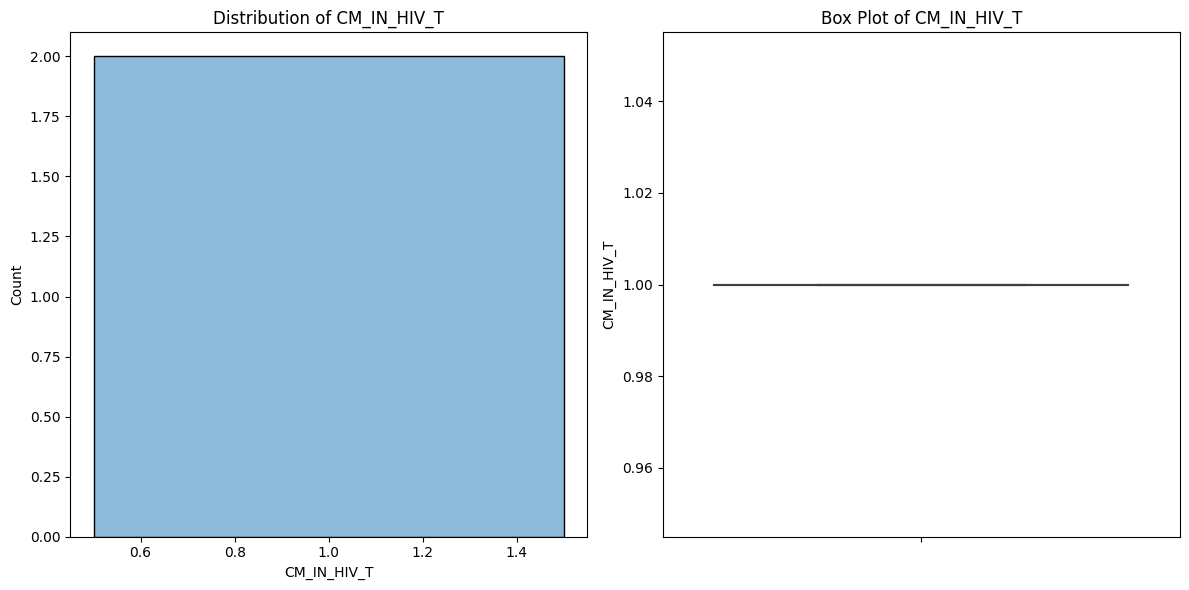


Statistics for CM_IN_HIV_T:
Count: 2
Missing: 562
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


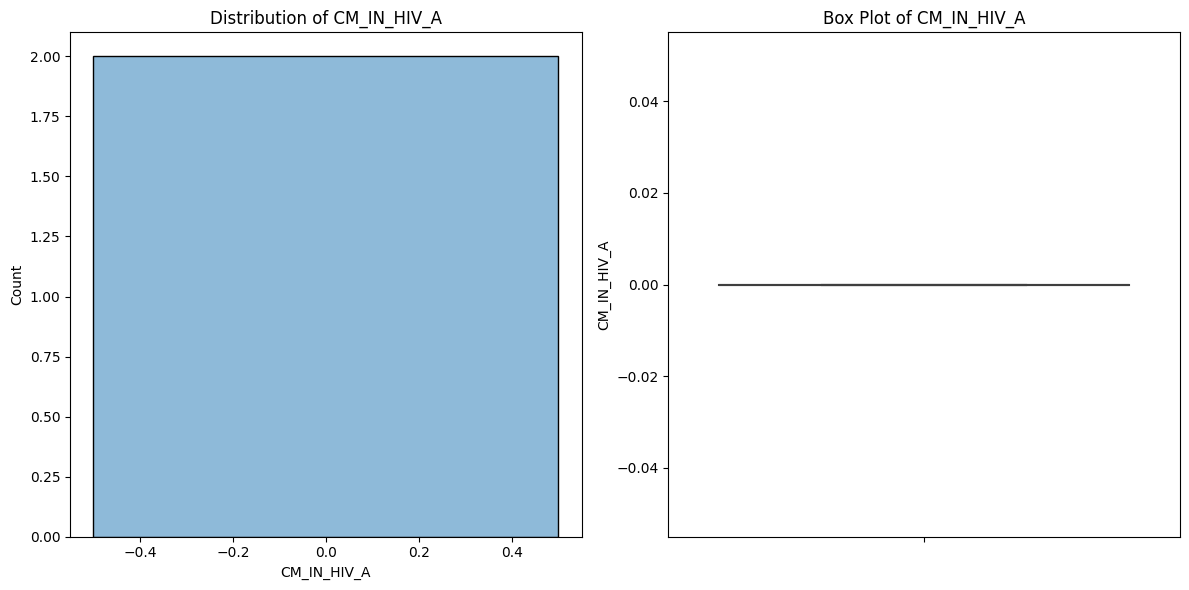


Statistics for CM_IN_HIV_A:
Count: 2
Missing: 562
Mean: 0.00
Median: 0.00
Std: 0.00
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


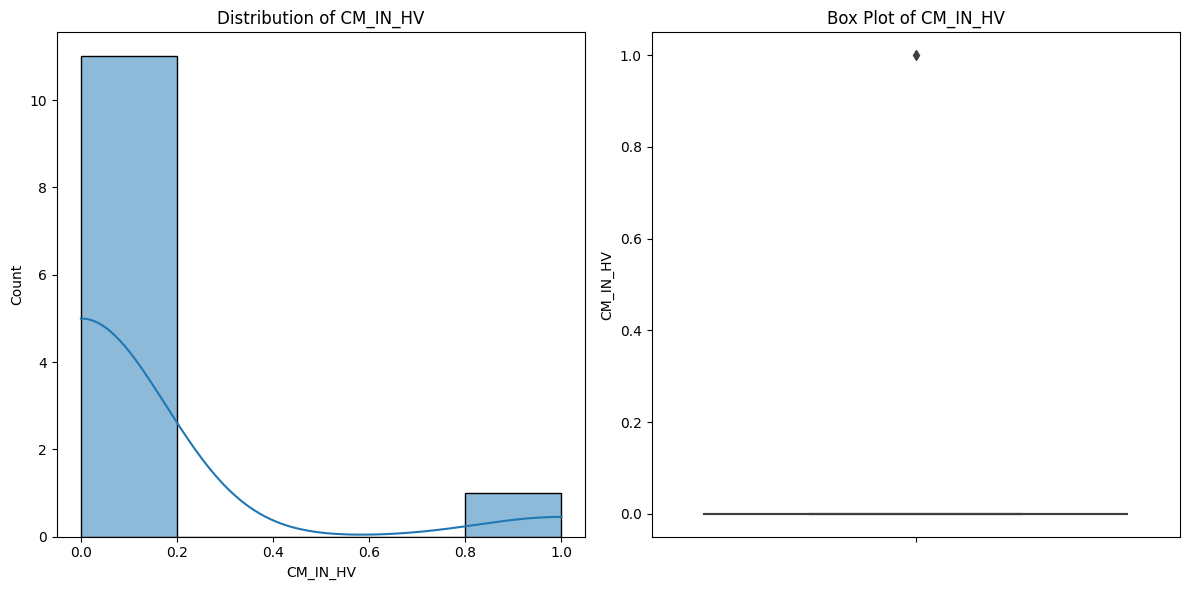


Statistics for CM_IN_HV:
Count: 12
Missing: 552
Mean: 0.08
Median: 0.00
Std: 0.29
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


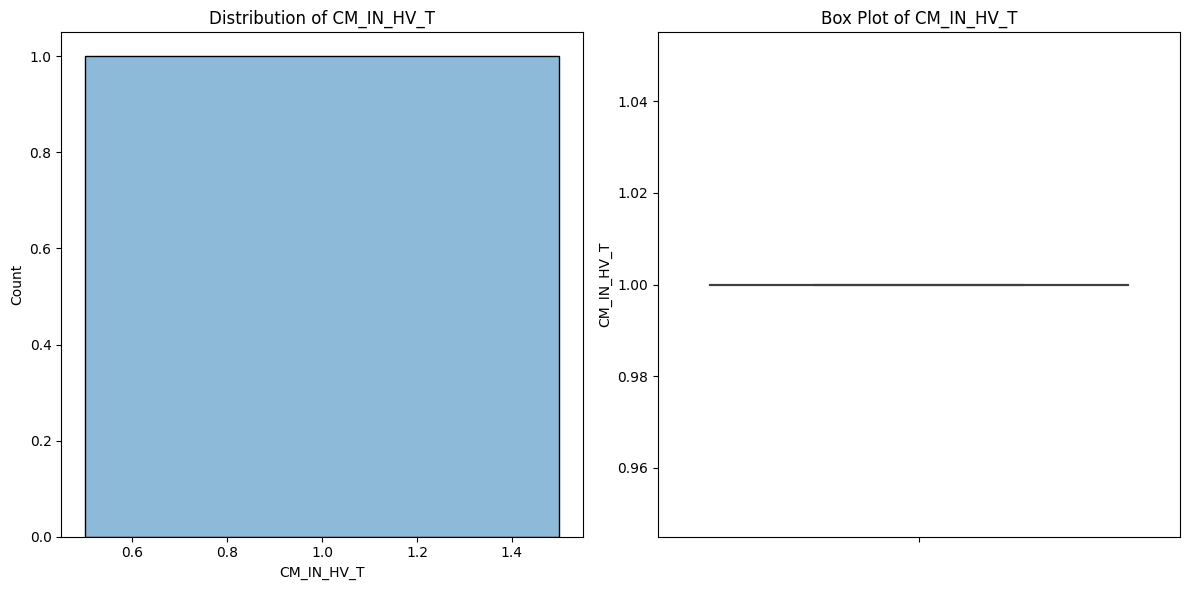


Statistics for CM_IN_HV_T:
Count: 1
Missing: 563
Mean: 1.00
Median: 1.00
Std: nan
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


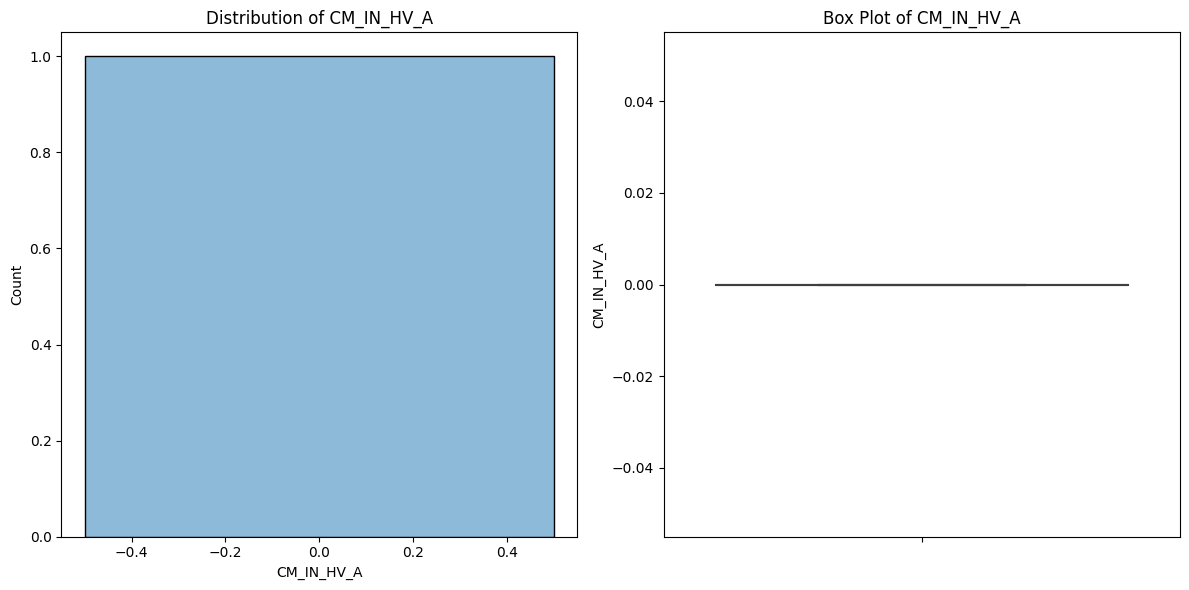


Statistics for CM_IN_HV_A:
Count: 1
Missing: 563
Mean: 0.00
Median: 0.00
Std: nan
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


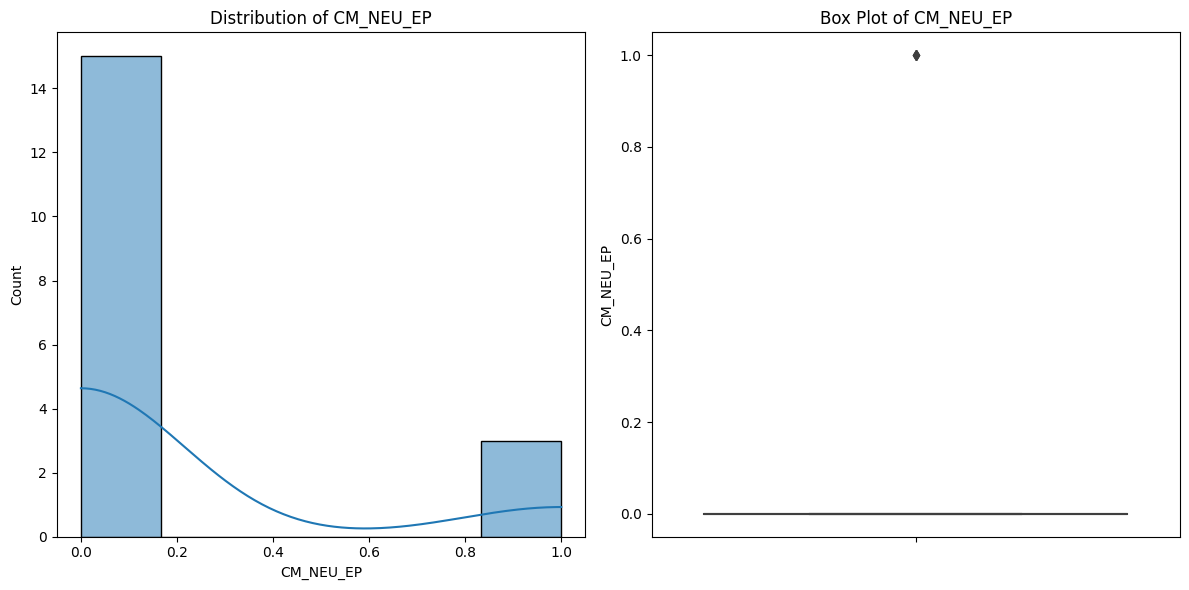


Statistics for CM_NEU_EP:
Count: 18
Missing: 546
Mean: 0.17
Median: 0.00
Std: 0.38
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


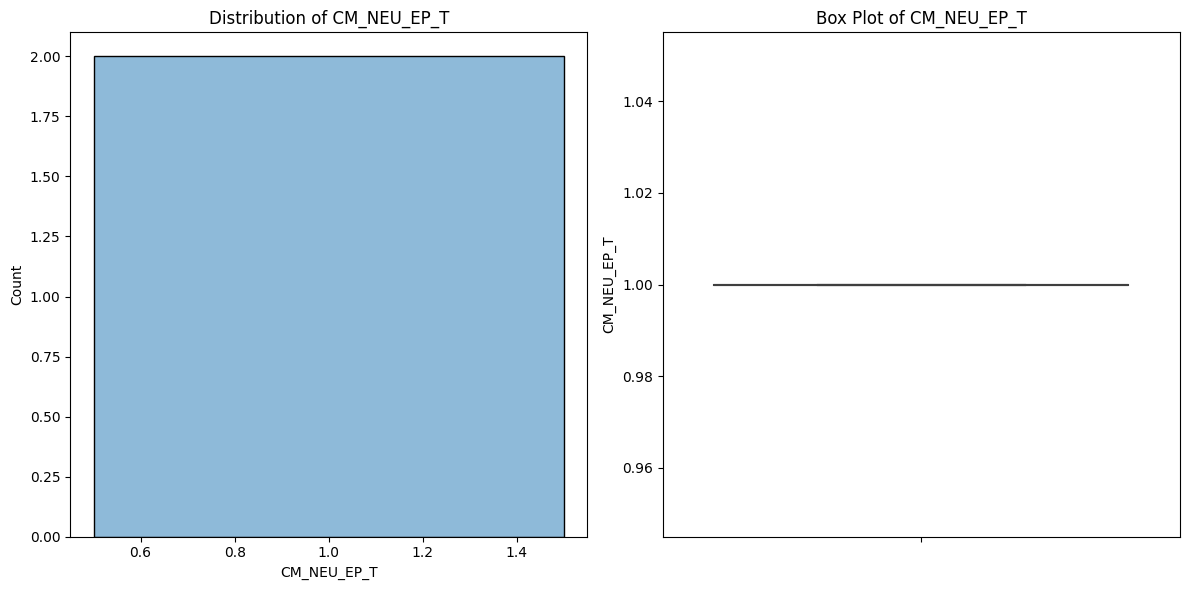


Statistics for CM_NEU_EP_T:
Count: 2
Missing: 562
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


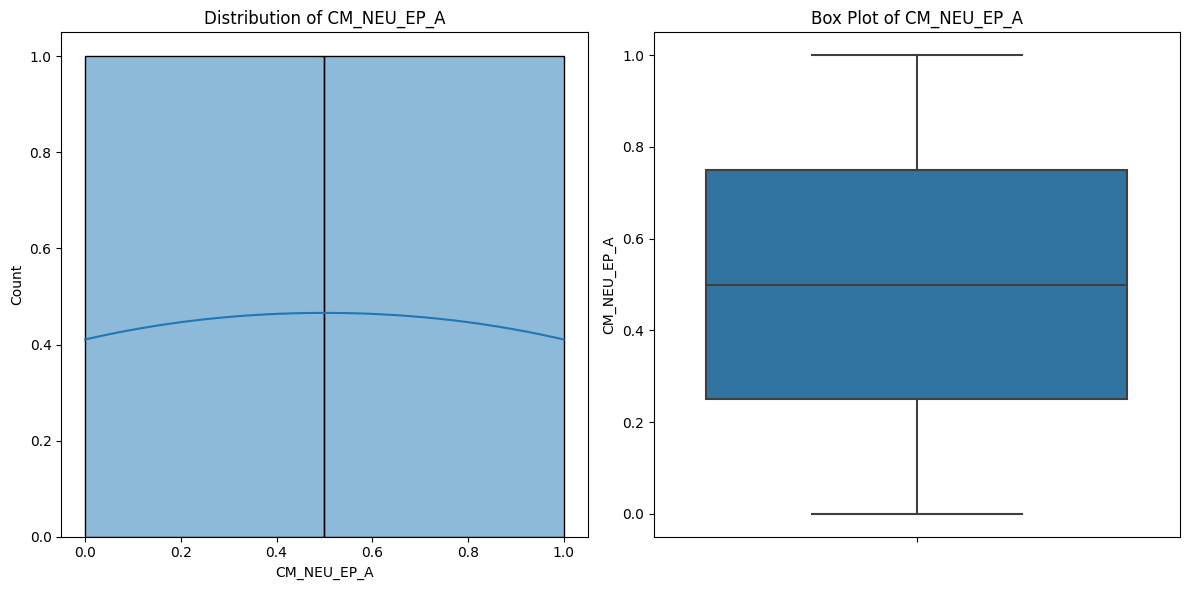


Statistics for CM_NEU_EP_A:
Count: 2
Missing: 562
Mean: 0.50
Median: 0.50
Std: 0.71
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


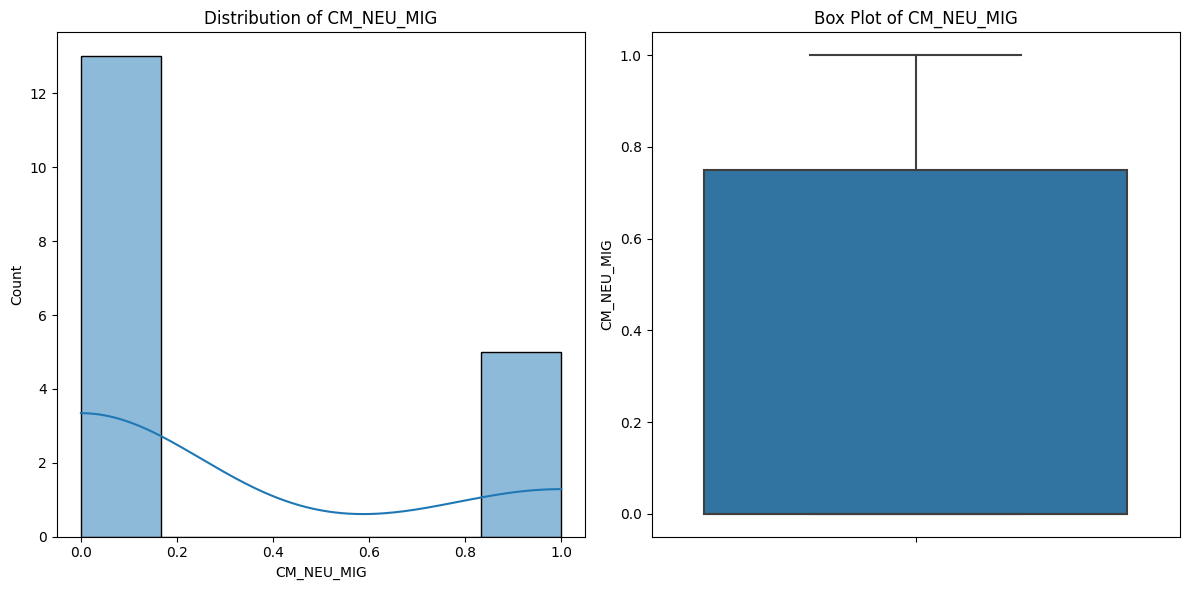


Statistics for CM_NEU_MIG:
Count: 18
Missing: 546
Mean: 0.28
Median: 0.00
Std: 0.46
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


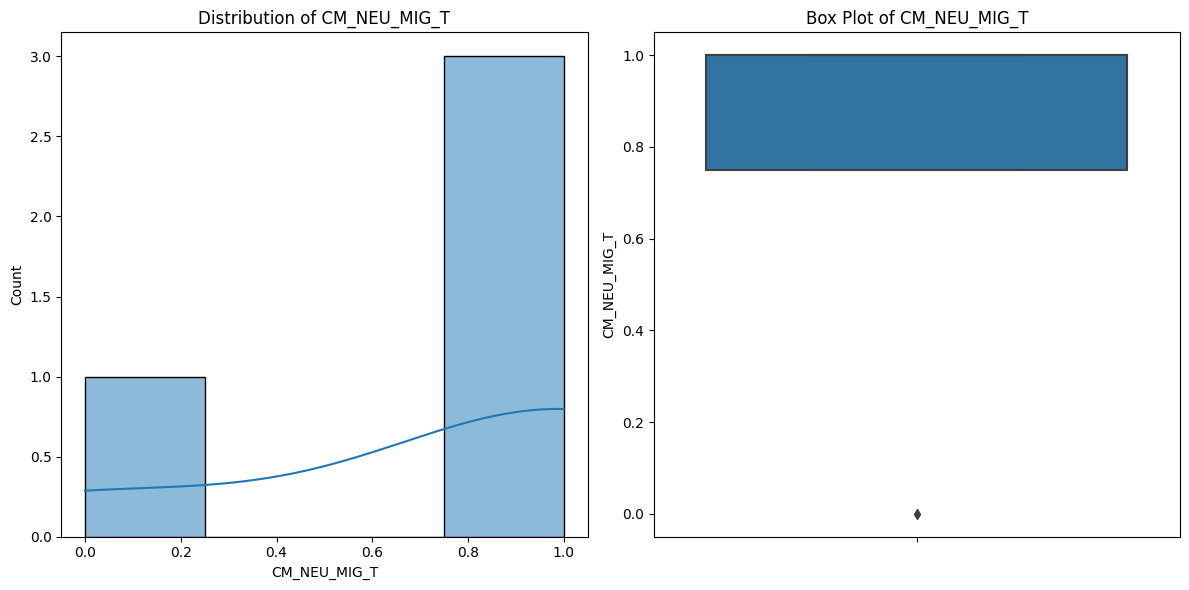


Statistics for CM_NEU_MIG_T:
Count: 4
Missing: 560
Mean: 0.75
Median: 1.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


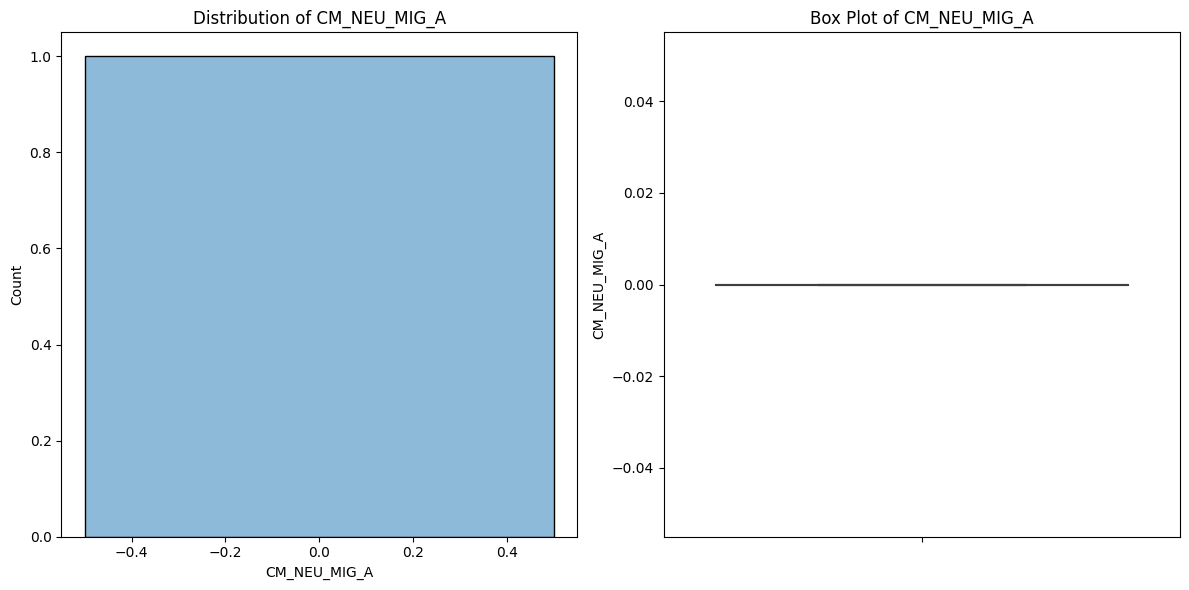


Statistics for CM_NEU_MIG_A:
Count: 1
Missing: 563
Mean: 0.00
Median: 0.00
Std: nan
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


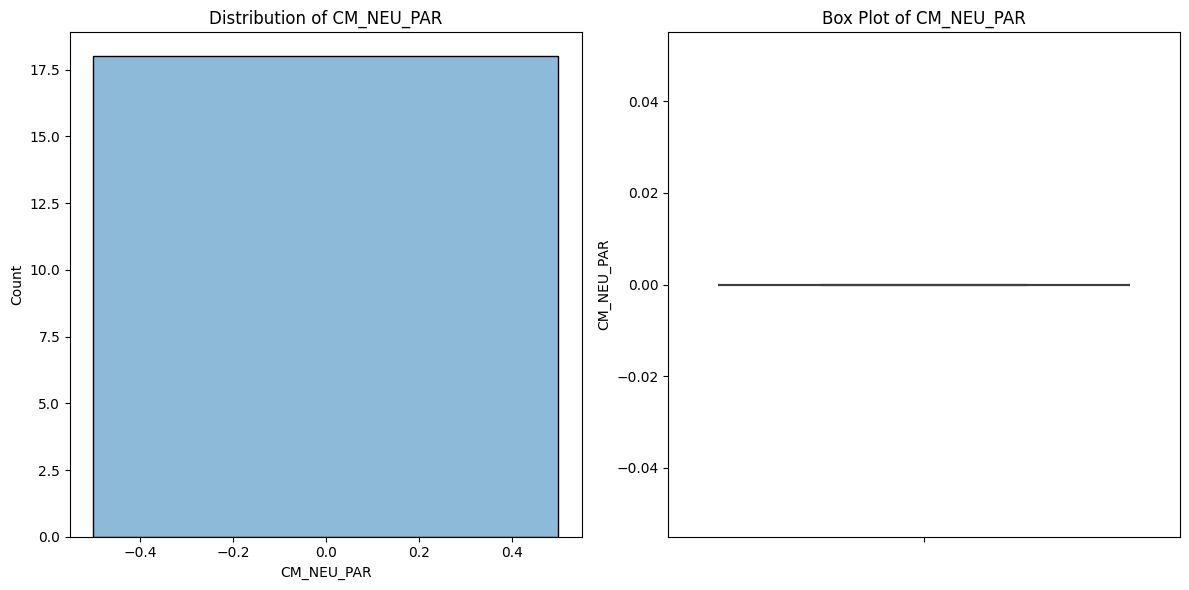


Statistics for CM_NEU_PAR:
Count: 18
Missing: 546
Mean: 0.00
Median: 0.00
Std: 0.00
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


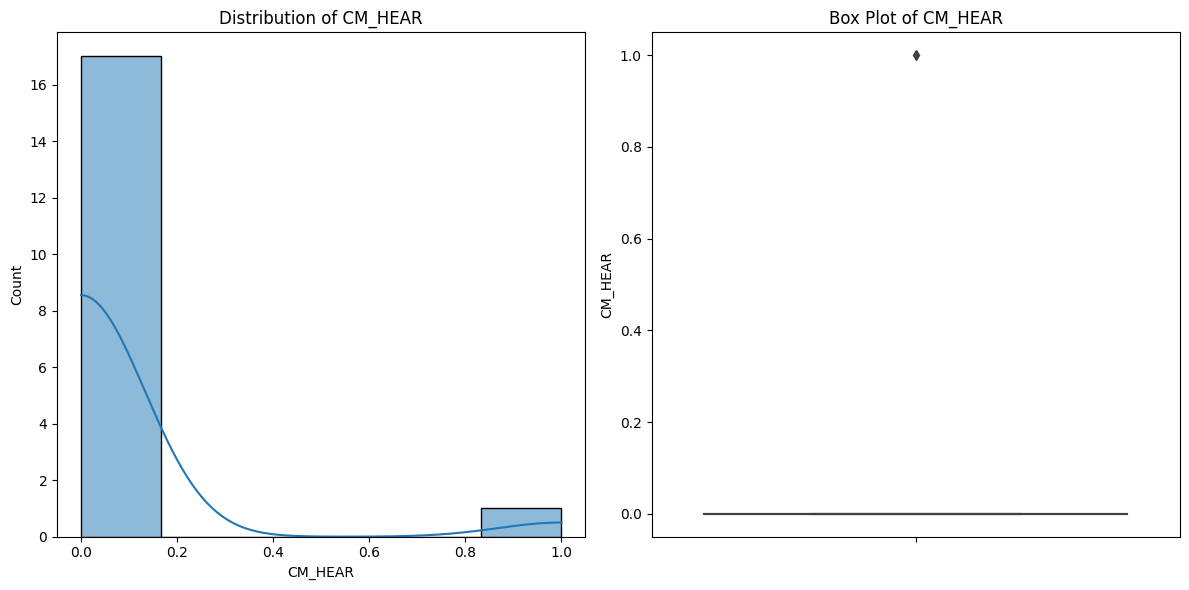


Statistics for CM_HEAR:
Count: 18
Missing: 546
Mean: 0.06
Median: 0.00
Std: 0.24
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


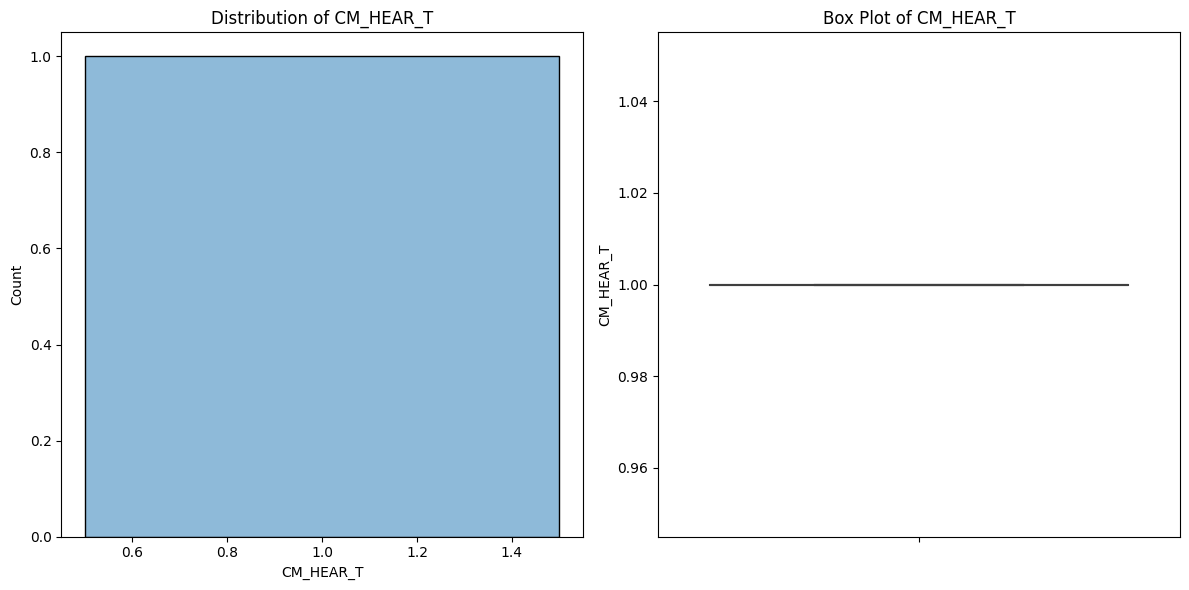


Statistics for CM_HEAR_T:
Count: 1
Missing: 563
Mean: 1.00
Median: 1.00
Std: nan
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


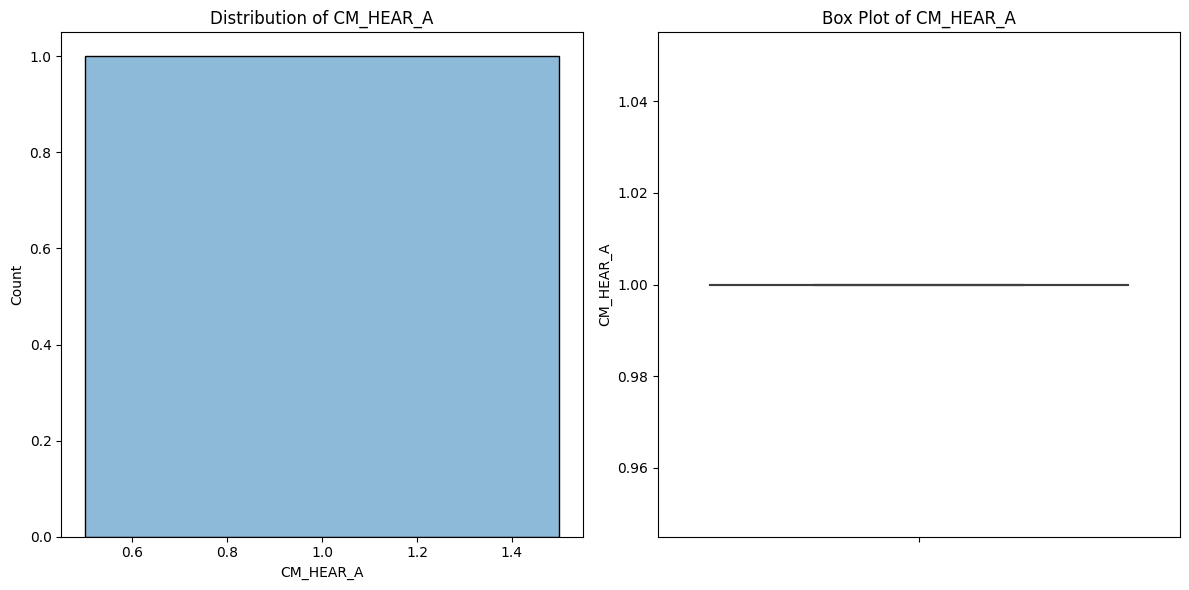


Statistics for CM_HEAR_A:
Count: 1
Missing: 563
Mean: 1.00
Median: 1.00
Std: nan
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


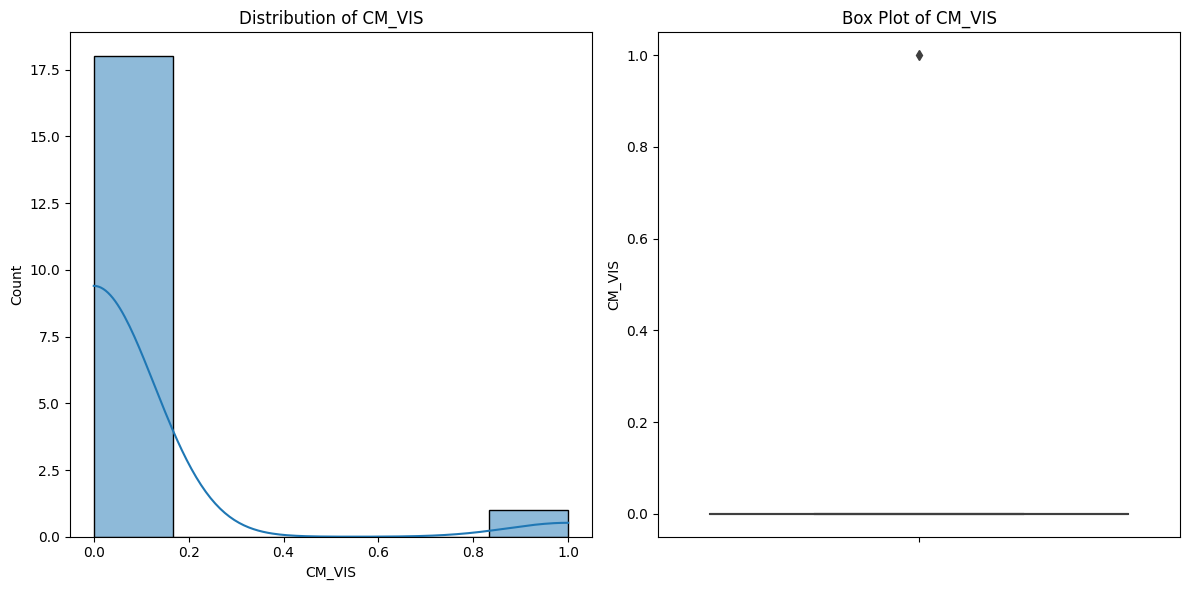


Statistics for CM_VIS:
Count: 19
Missing: 545
Mean: 0.05
Median: 0.00
Std: 0.23
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


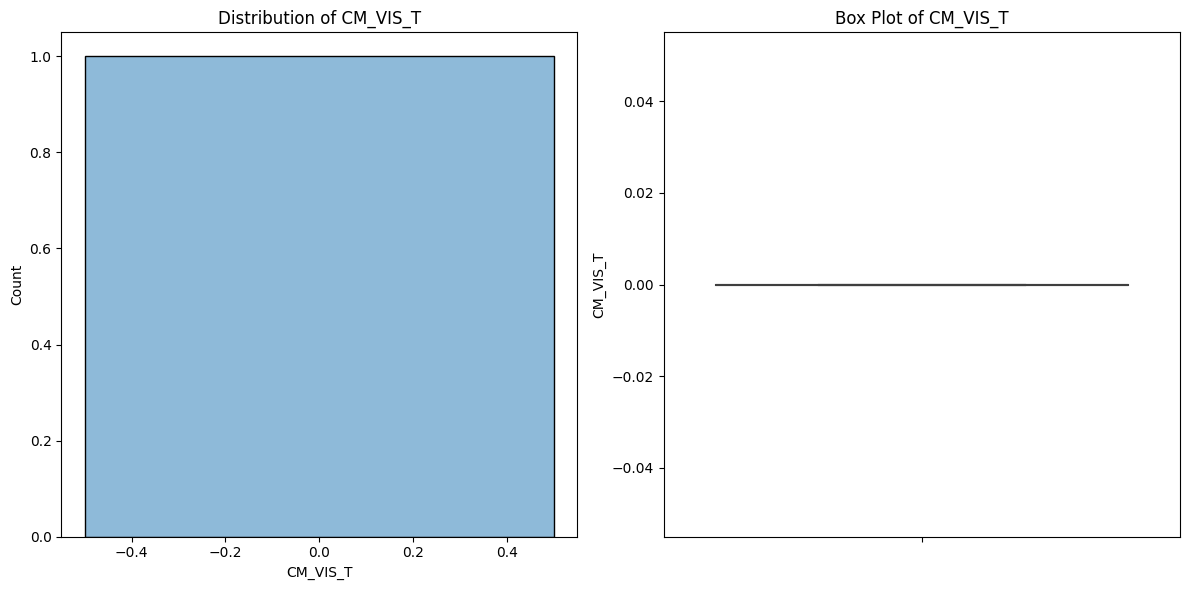


Statistics for CM_VIS_T:
Count: 1
Missing: 563
Mean: 0.00
Median: 0.00
Std: nan
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


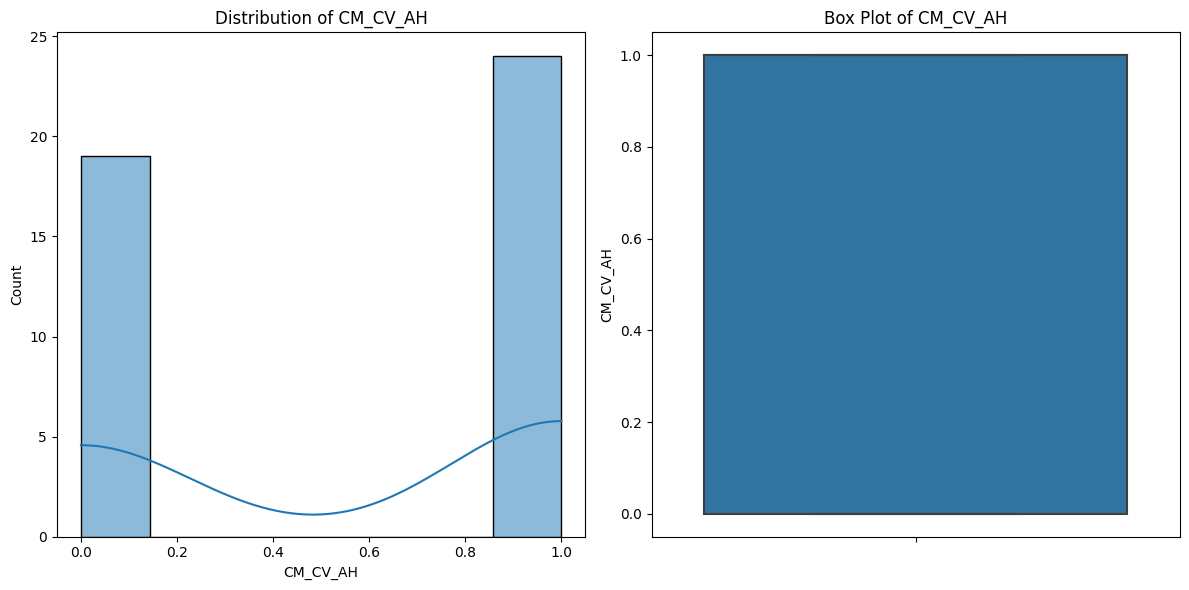


Statistics for CM_CV_AH:
Count: 43
Missing: 521
Mean: 0.56
Median: 1.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


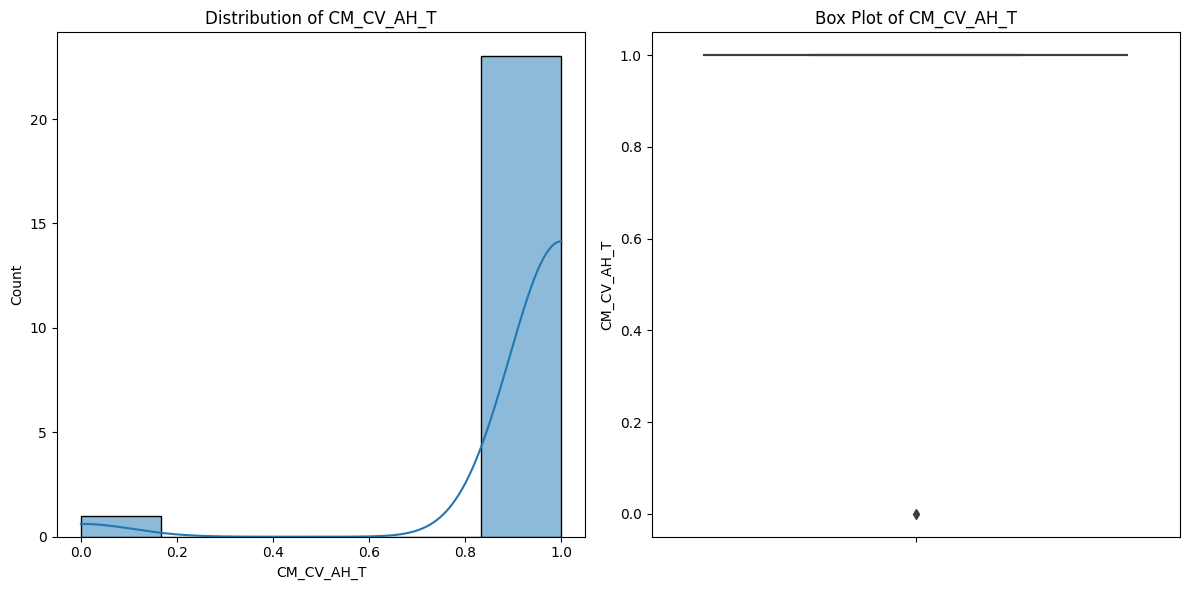


Statistics for CM_CV_AH_T:
Count: 24
Missing: 540
Mean: 0.96
Median: 1.00
Std: 0.20
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


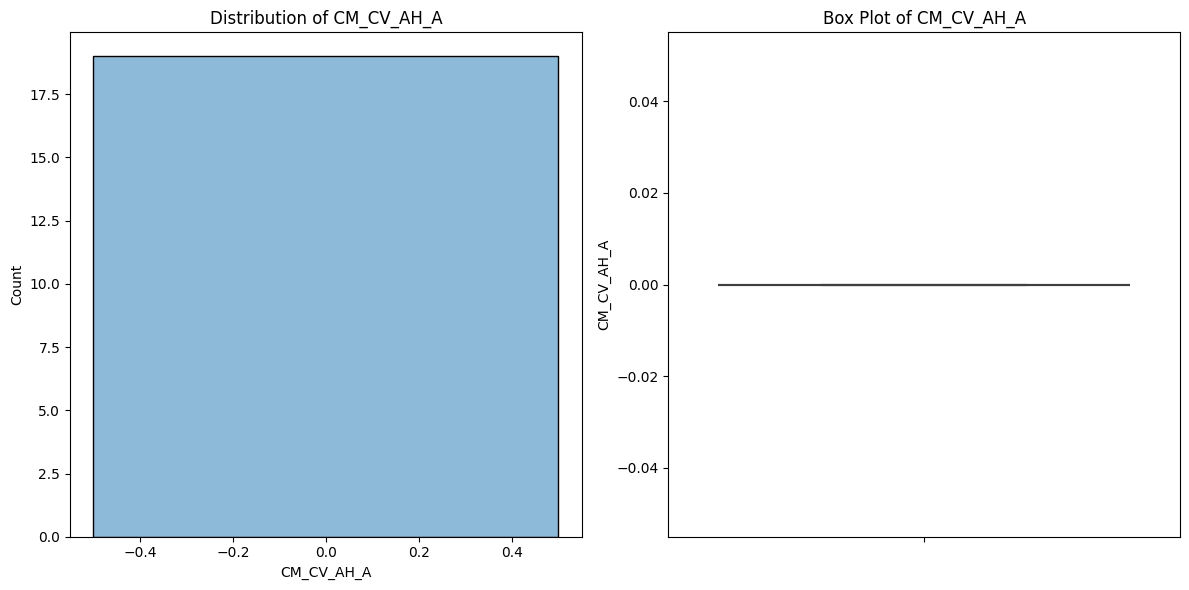


Statistics for CM_CV_AH_A:
Count: 19
Missing: 545
Mean: 0.00
Median: 0.00
Std: 0.00
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


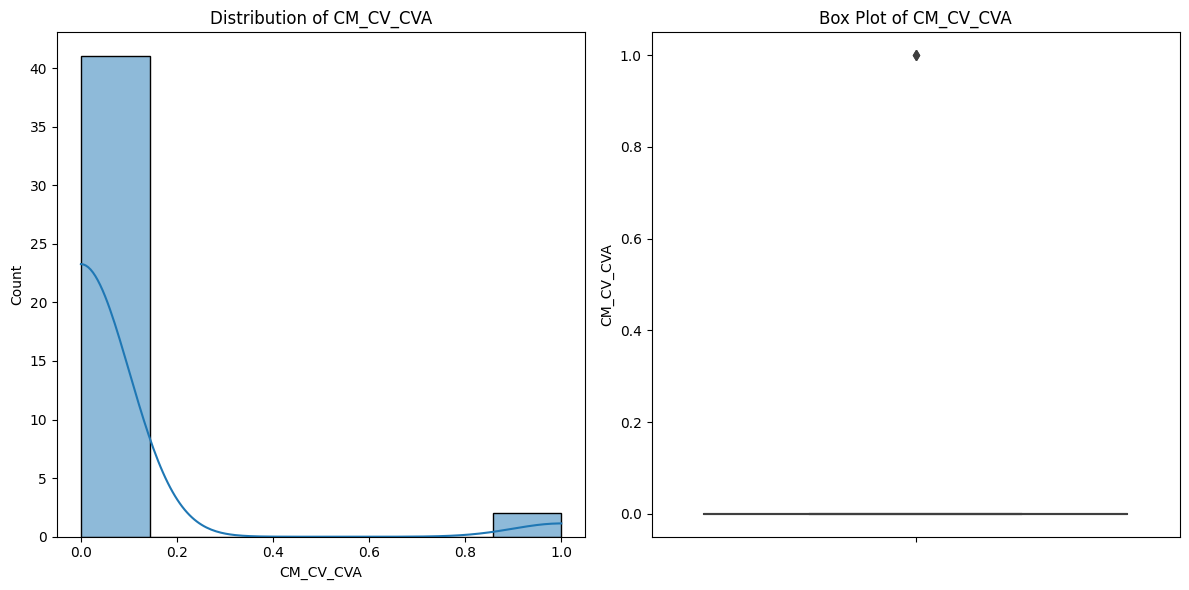


Statistics for CM_CV_CVA:
Count: 43
Missing: 521
Mean: 0.05
Median: 0.00
Std: 0.21
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


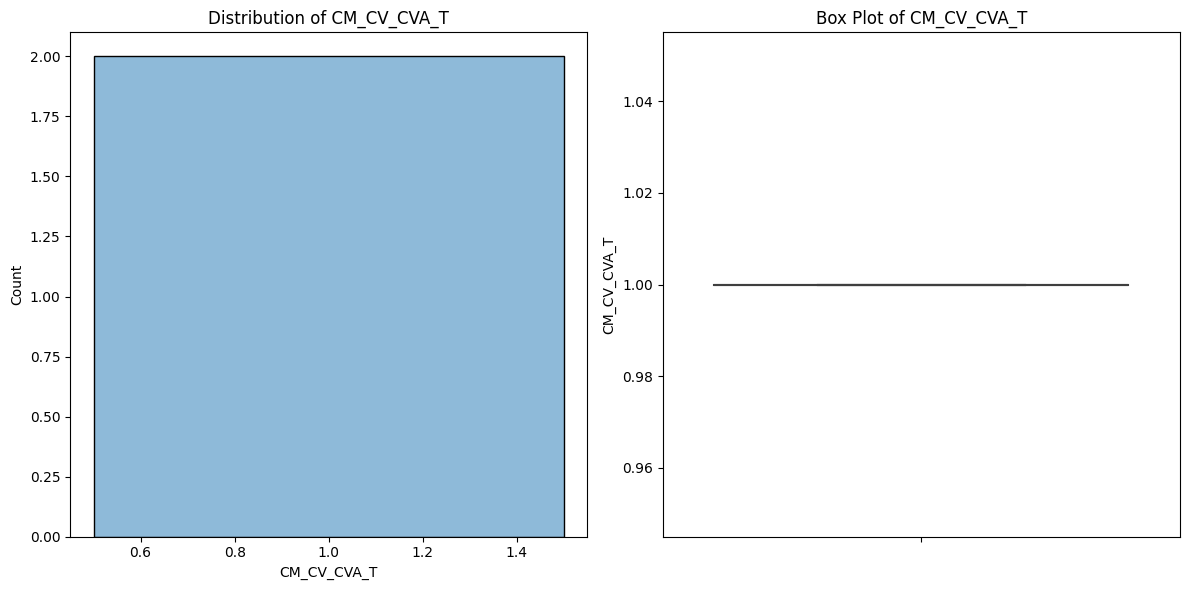


Statistics for CM_CV_CVA_T:
Count: 2
Missing: 562
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


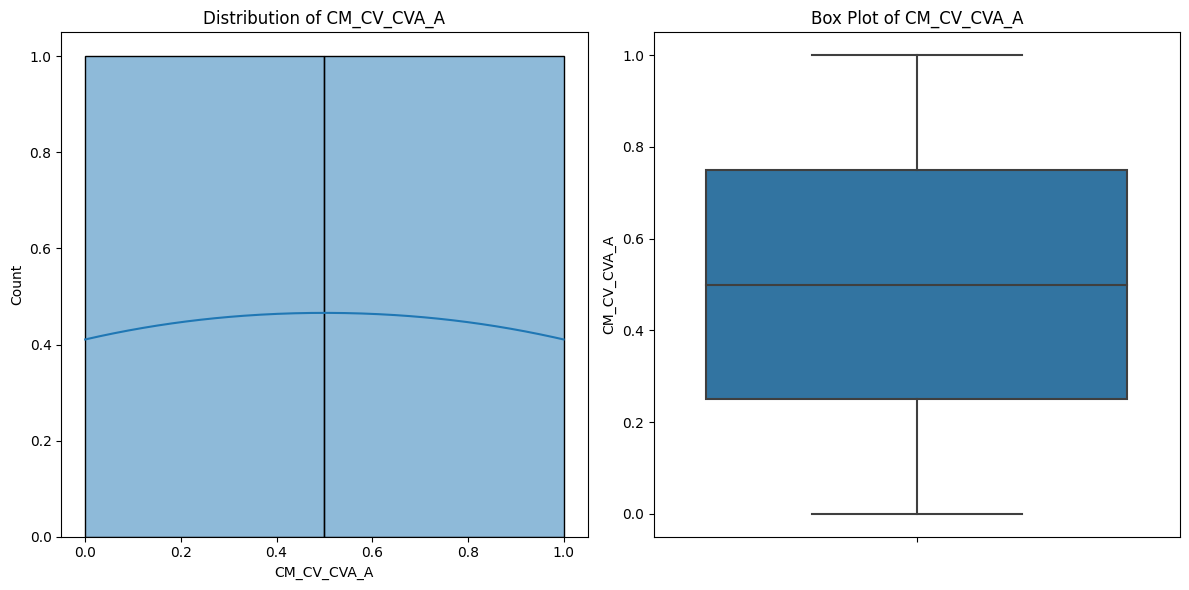


Statistics for CM_CV_CVA_A:
Count: 2
Missing: 562
Mean: 0.50
Median: 0.50
Std: 0.71
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


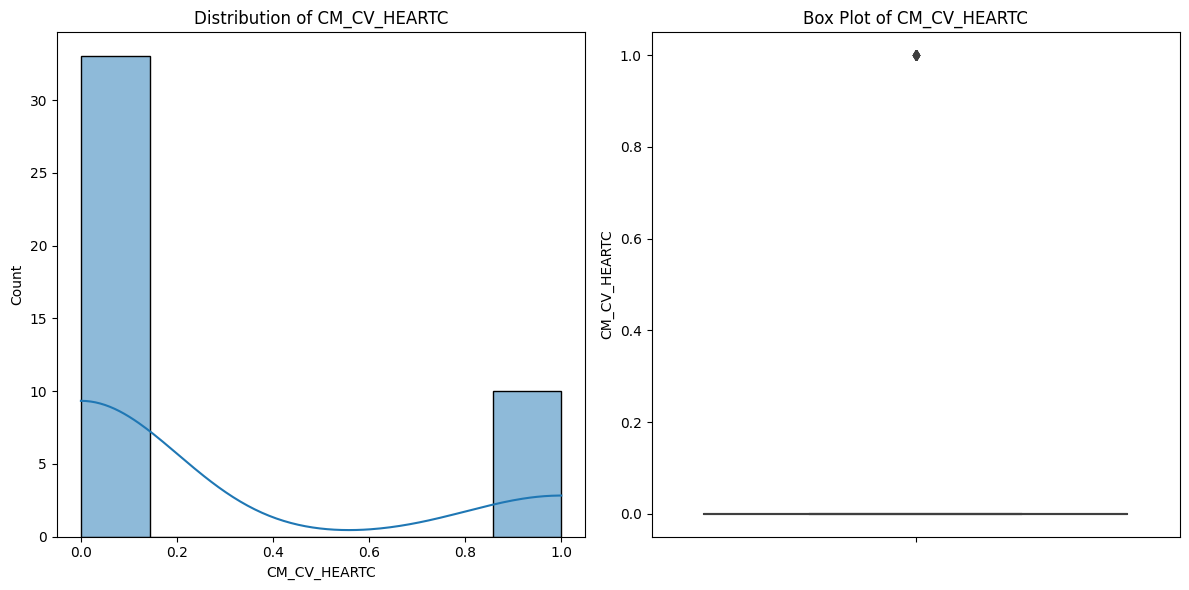


Statistics for CM_CV_HEARTC:
Count: 43
Missing: 521
Mean: 0.23
Median: 0.00
Std: 0.43
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


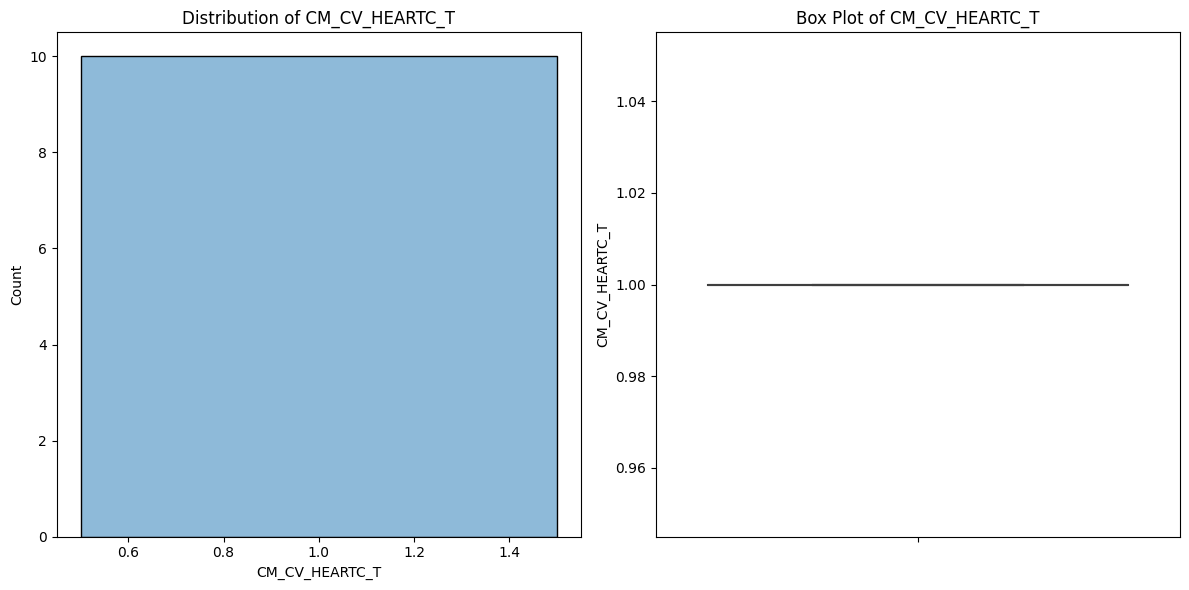


Statistics for CM_CV_HEARTC_T:
Count: 10
Missing: 554
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


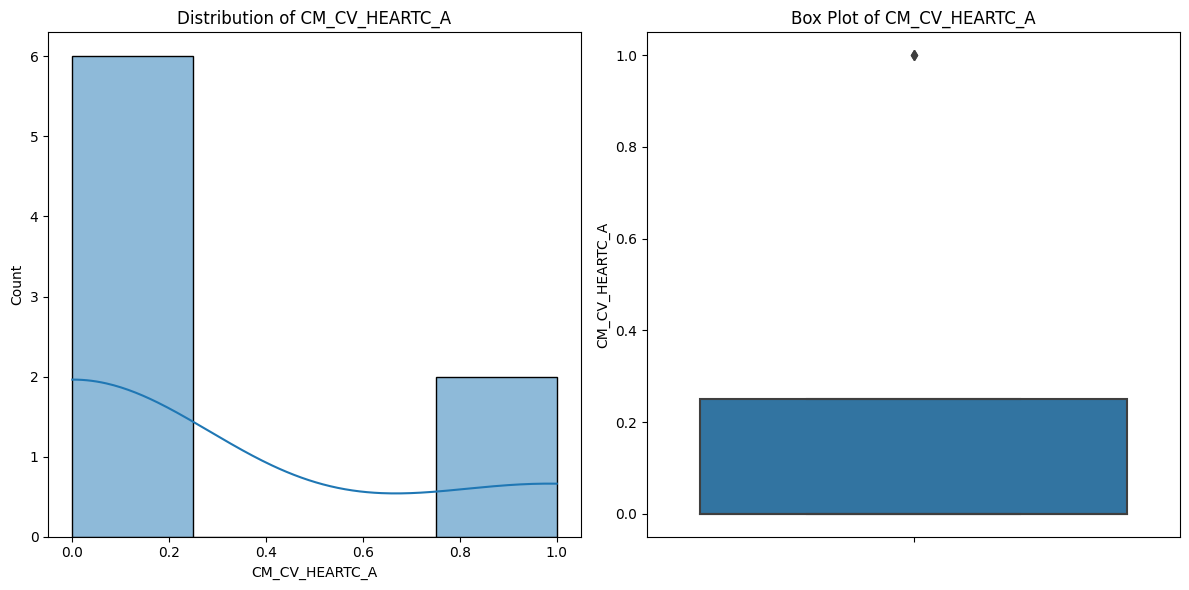


Statistics for CM_CV_HEARTC_A:
Count: 8
Missing: 556
Mean: 0.25
Median: 0.00
Std: 0.46
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


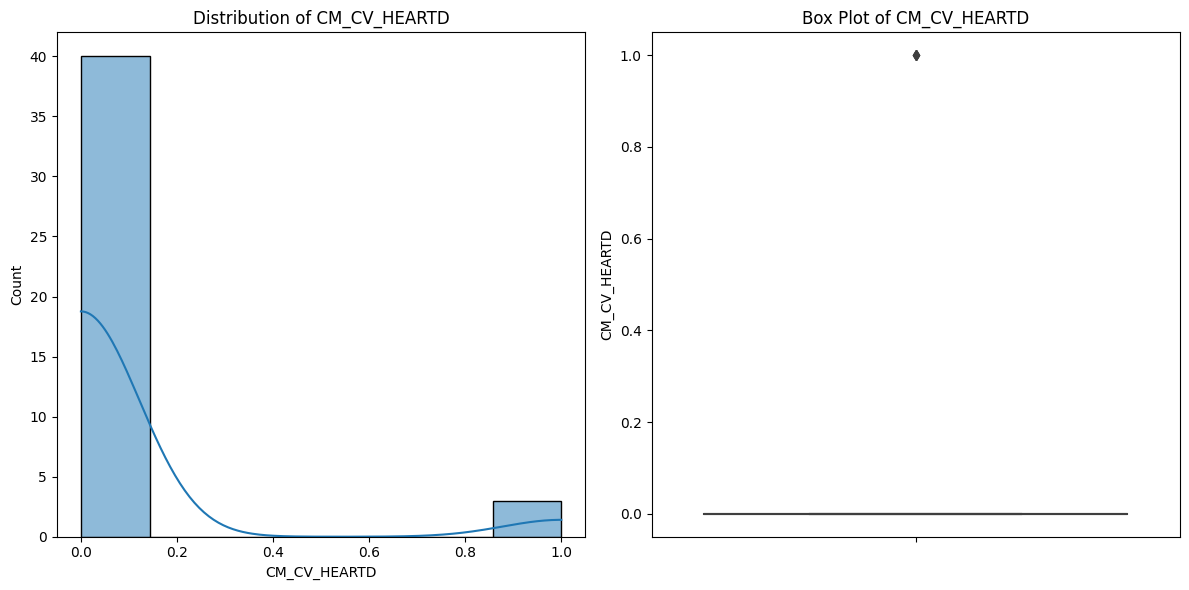


Statistics for CM_CV_HEARTD:
Count: 43
Missing: 521
Mean: 0.07
Median: 0.00
Std: 0.26
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


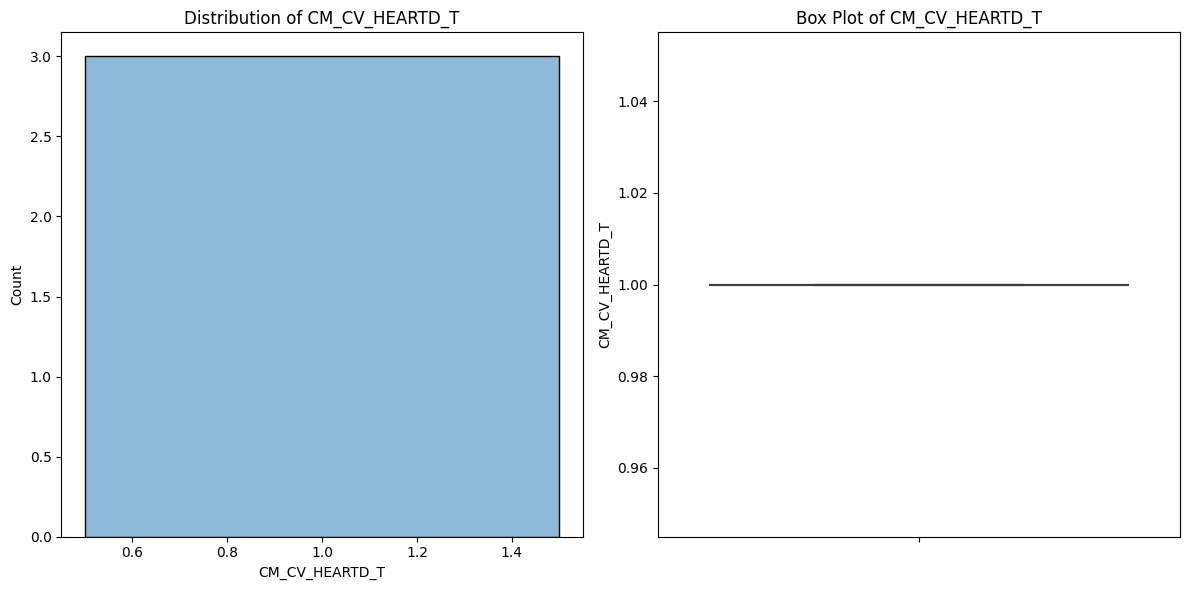


Statistics for CM_CV_HEARTD_T:
Count: 3
Missing: 561
Mean: 1.00
Median: 1.00
Std: 0.00
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


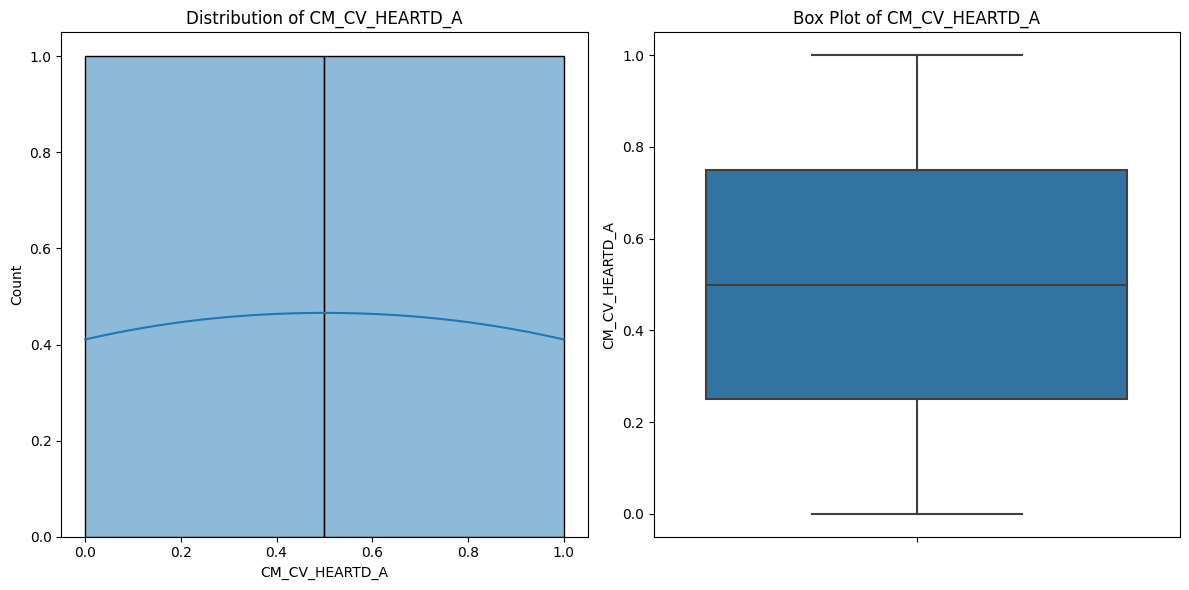


Statistics for CM_CV_HEARTD_A:
Count: 2
Missing: 562
Mean: 0.50
Median: 0.50
Std: 0.71
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


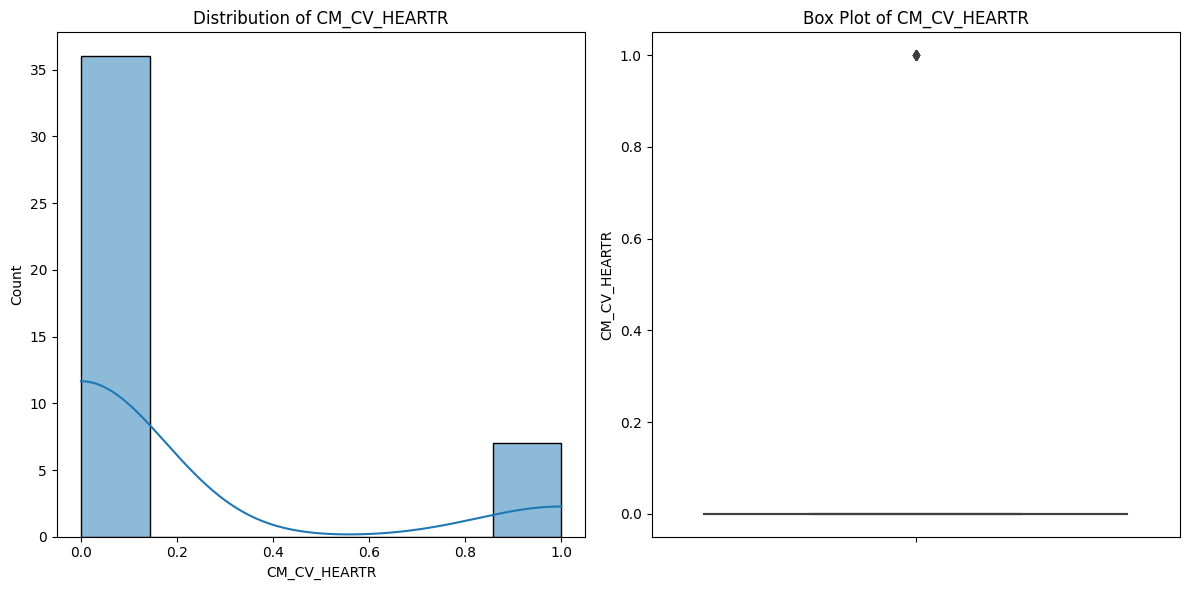


Statistics for CM_CV_HEARTR:
Count: 43
Missing: 521
Mean: 0.16
Median: 0.00
Std: 0.37
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


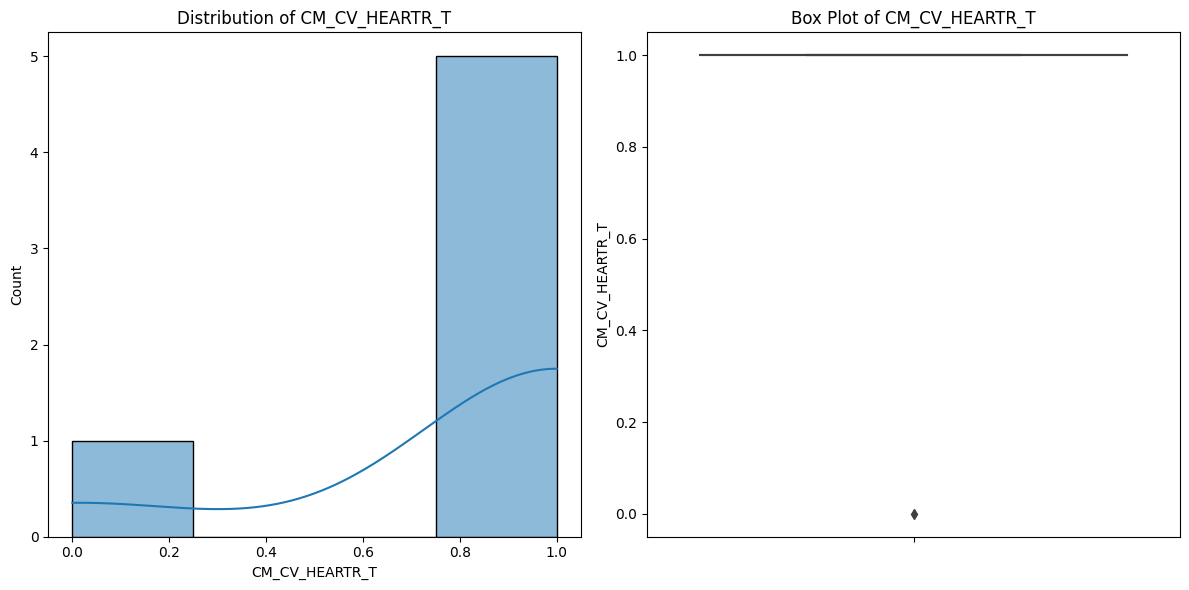


Statistics for CM_CV_HEARTR_T:
Count: 6
Missing: 558
Mean: 0.83
Median: 1.00
Std: 0.41
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


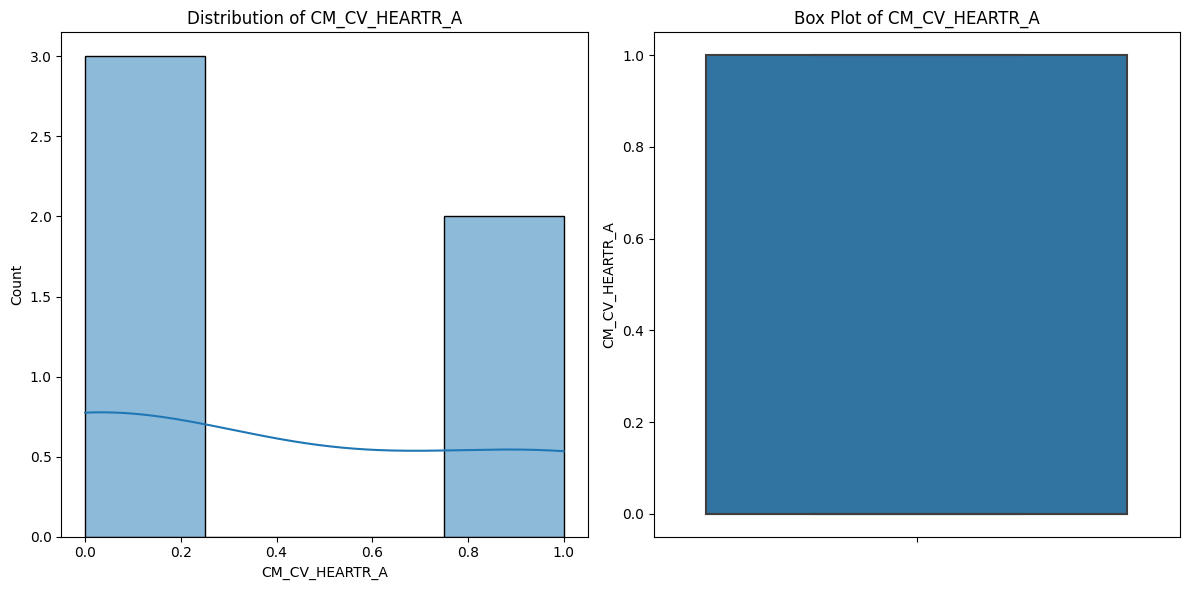


Statistics for CM_CV_HEARTR_A:
Count: 5
Missing: 559
Mean: 0.40
Median: 0.00
Std: 0.55
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


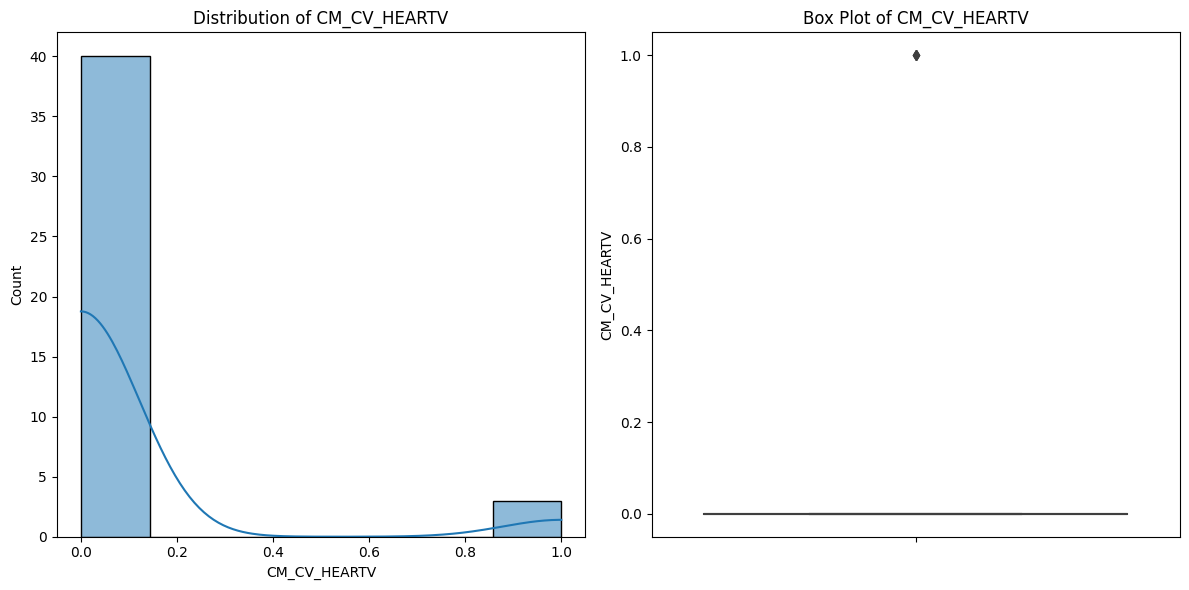


Statistics for CM_CV_HEARTV:
Count: 43
Missing: 521
Mean: 0.07
Median: 0.00
Std: 0.26
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


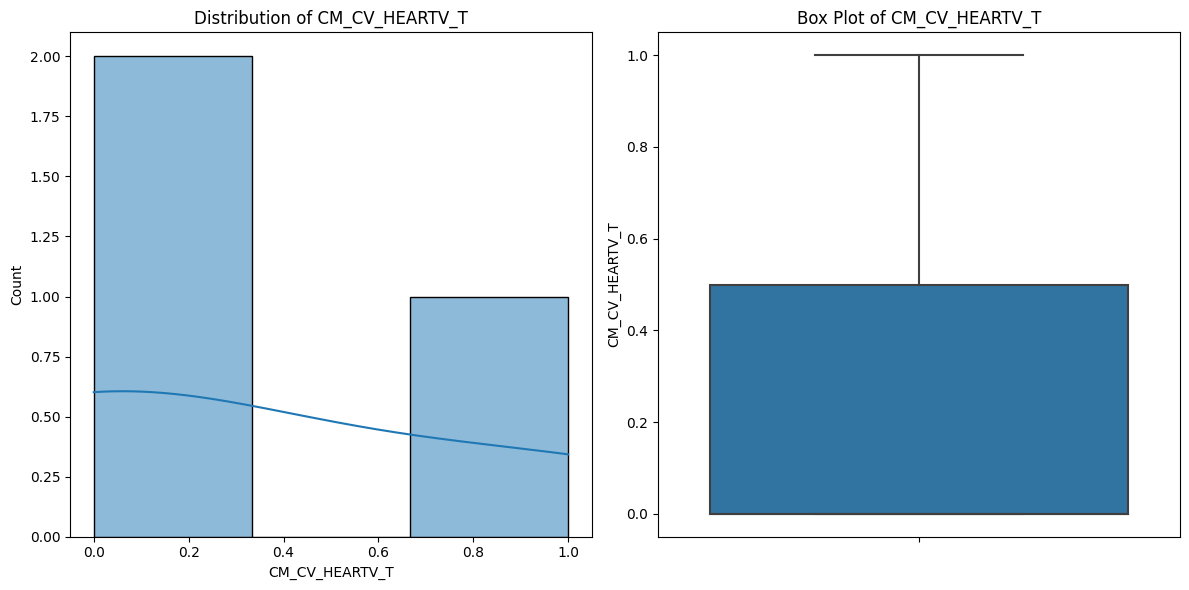


Statistics for CM_CV_HEARTV_T:
Count: 3
Missing: 561
Mean: 0.33
Median: 0.00
Std: 0.58
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


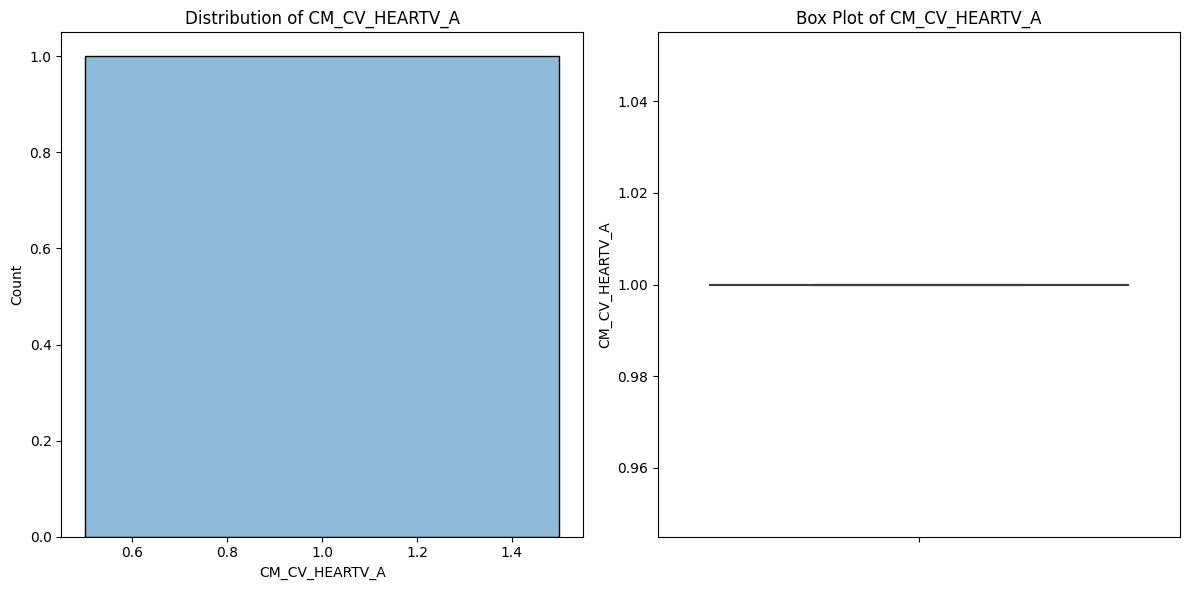


Statistics for CM_CV_HEARTV_A:
Count: 1
Missing: 563
Mean: 1.00
Median: 1.00
Std: nan
Min: 1.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


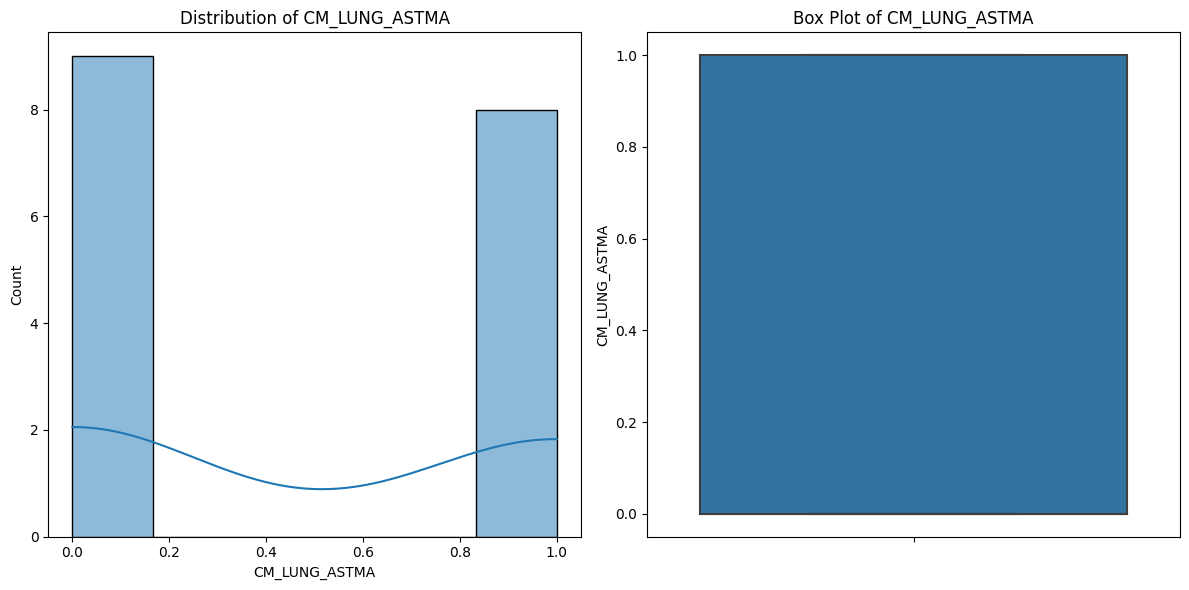


Statistics for CM_LUNG_ASTMA:
Count: 17
Missing: 547
Mean: 0.47
Median: 0.00
Std: 0.51
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


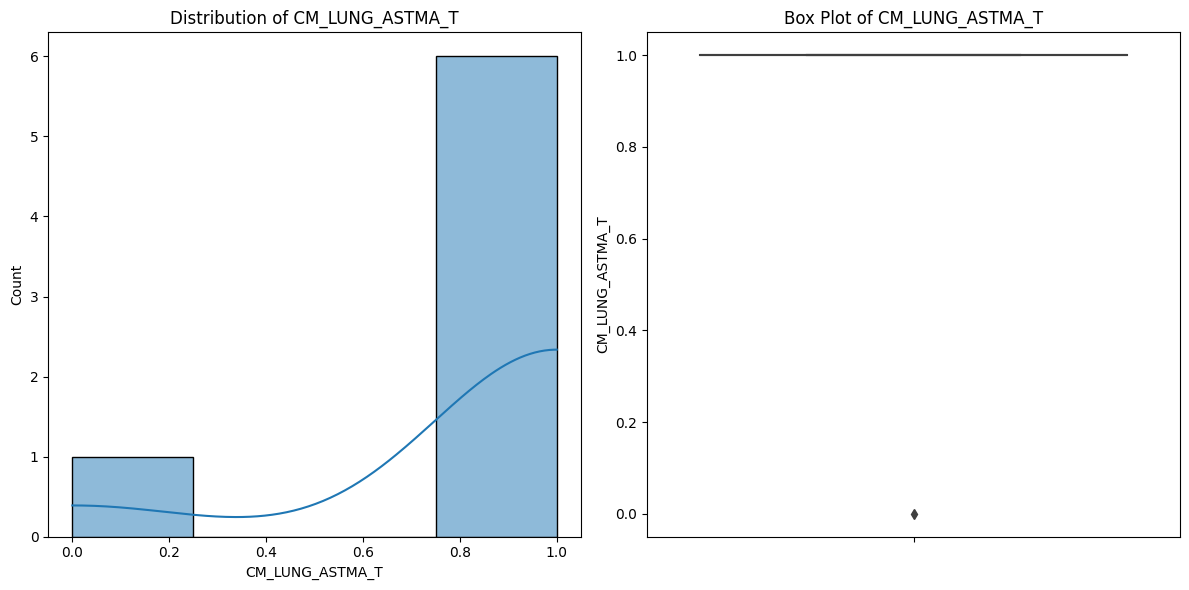


Statistics for CM_LUNG_ASTMA_T:
Count: 7
Missing: 557
Mean: 0.86
Median: 1.00
Std: 0.38
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


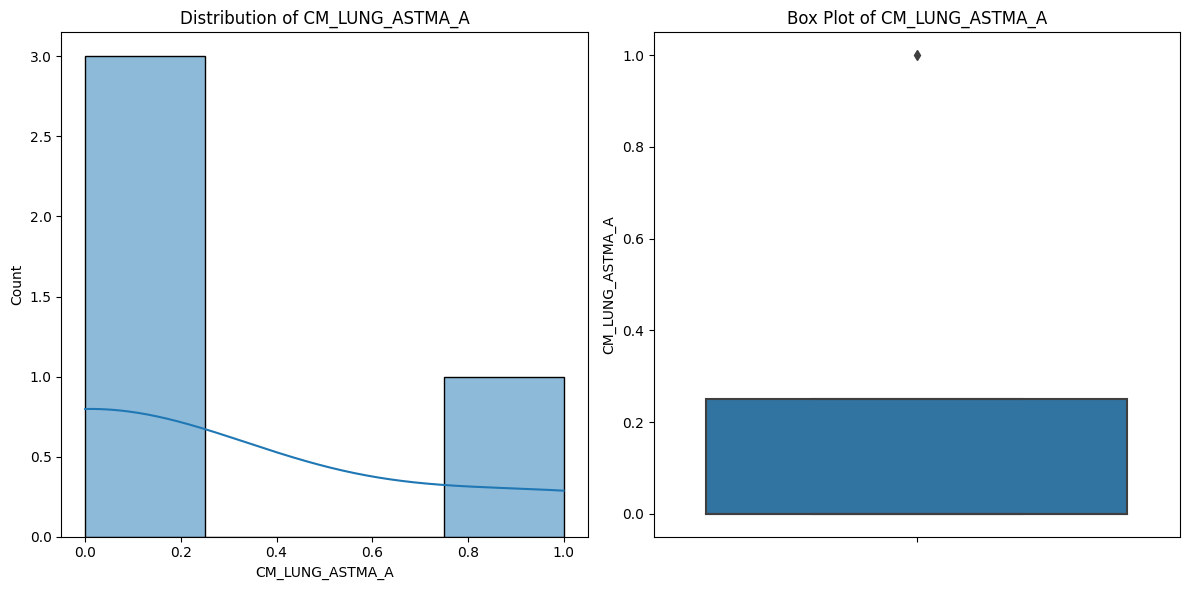


Statistics for CM_LUNG_ASTMA_A:
Count: 4
Missing: 560
Mean: 0.25
Median: 0.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


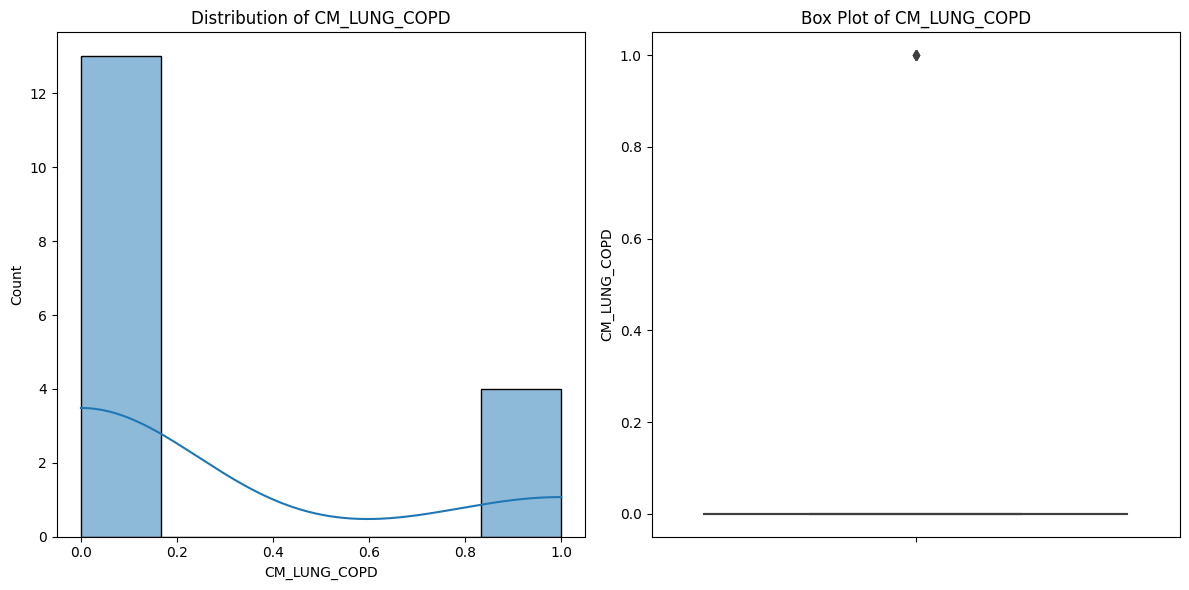


Statistics for CM_LUNG_COPD:
Count: 17
Missing: 547
Mean: 0.24
Median: 0.00
Std: 0.44
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


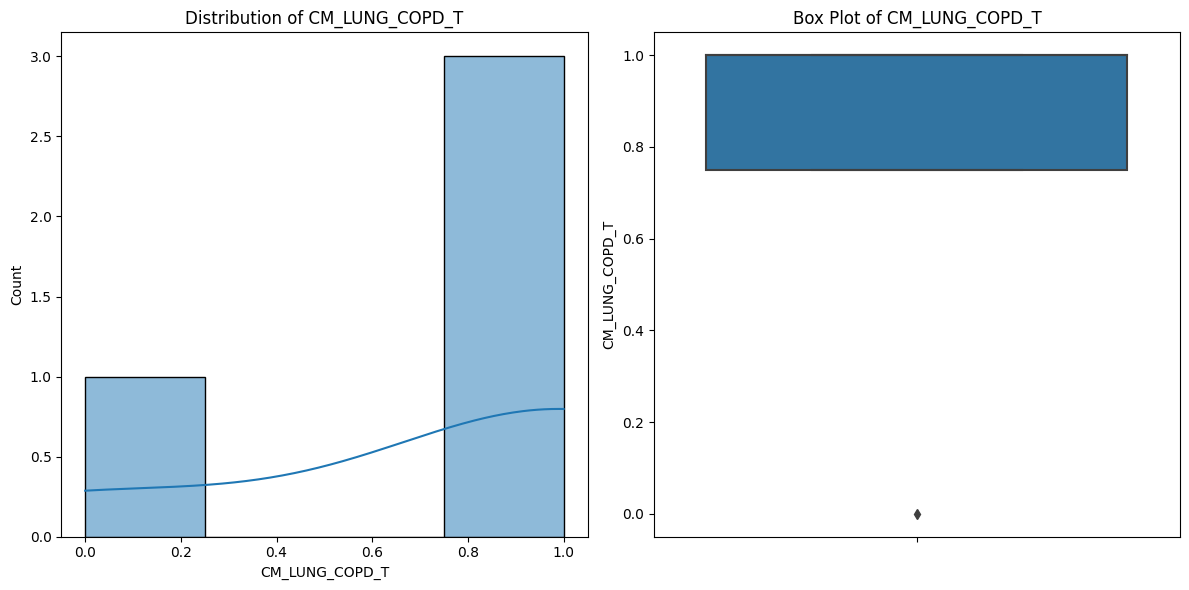


Statistics for CM_LUNG_COPD_T:
Count: 4
Missing: 560
Mean: 0.75
Median: 1.00
Std: 0.50
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


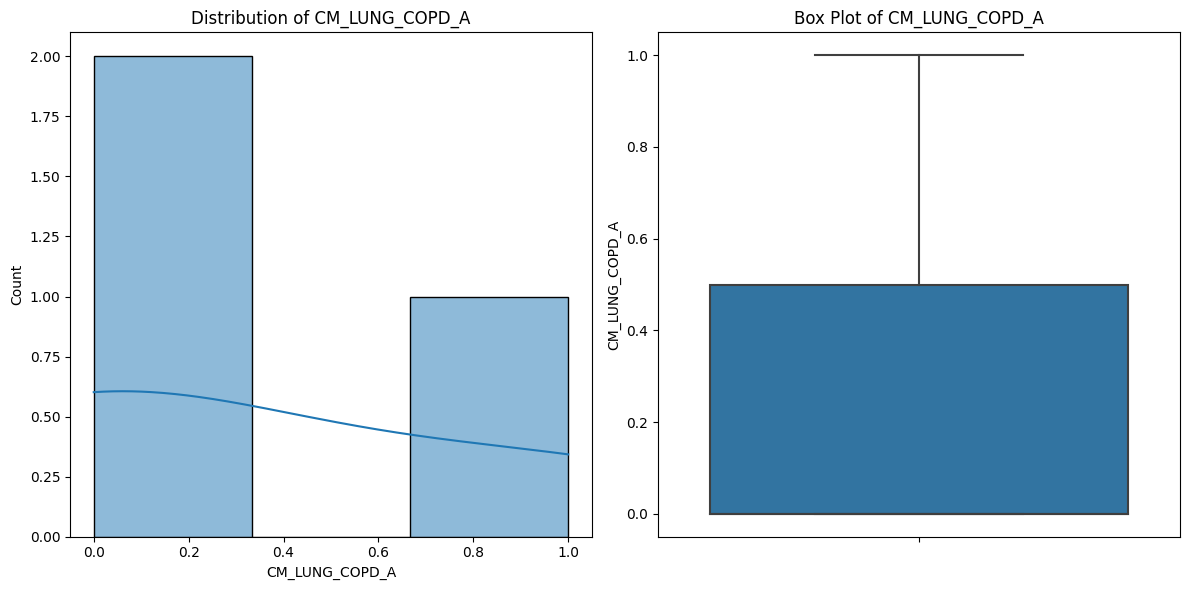


Statistics for CM_LUNG_COPD_A:
Count: 3
Missing: 561
Mean: 0.33
Median: 0.00
Std: 0.58
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


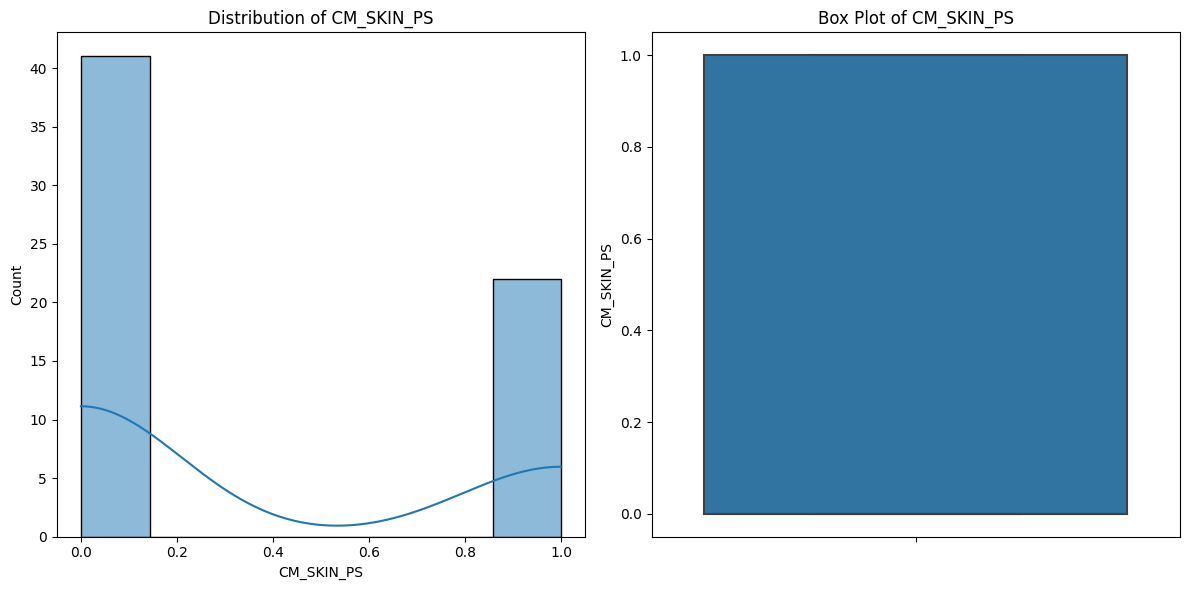


Statistics for CM_SKIN_PS:
Count: 63
Missing: 501
Mean: 0.35
Median: 0.00
Std: 0.48
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


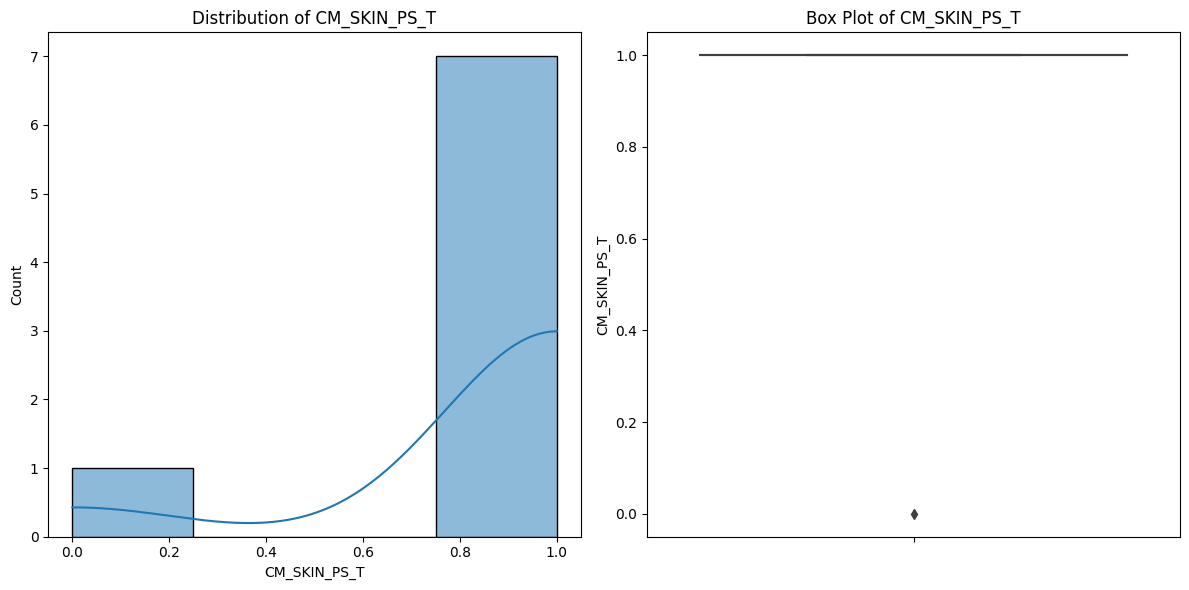


Statistics for CM_SKIN_PS_T:
Count: 8
Missing: 556
Mean: 0.88
Median: 1.00
Std: 0.35
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


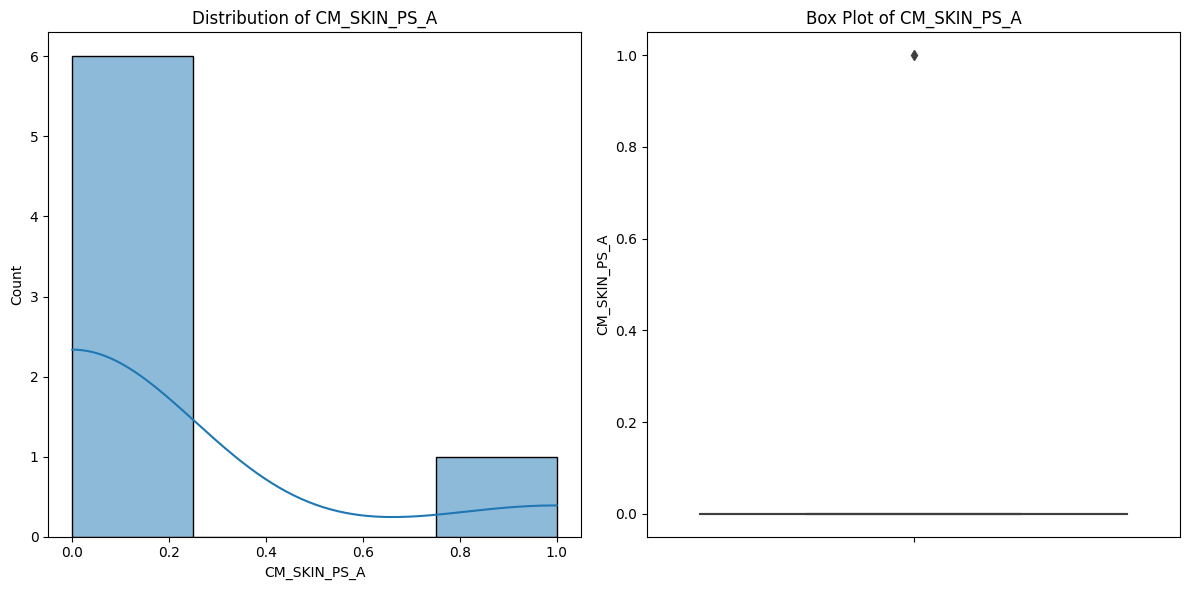


Statistics for CM_SKIN_PS_A:
Count: 7
Missing: 557
Mean: 0.14
Median: 0.00
Std: 0.38
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


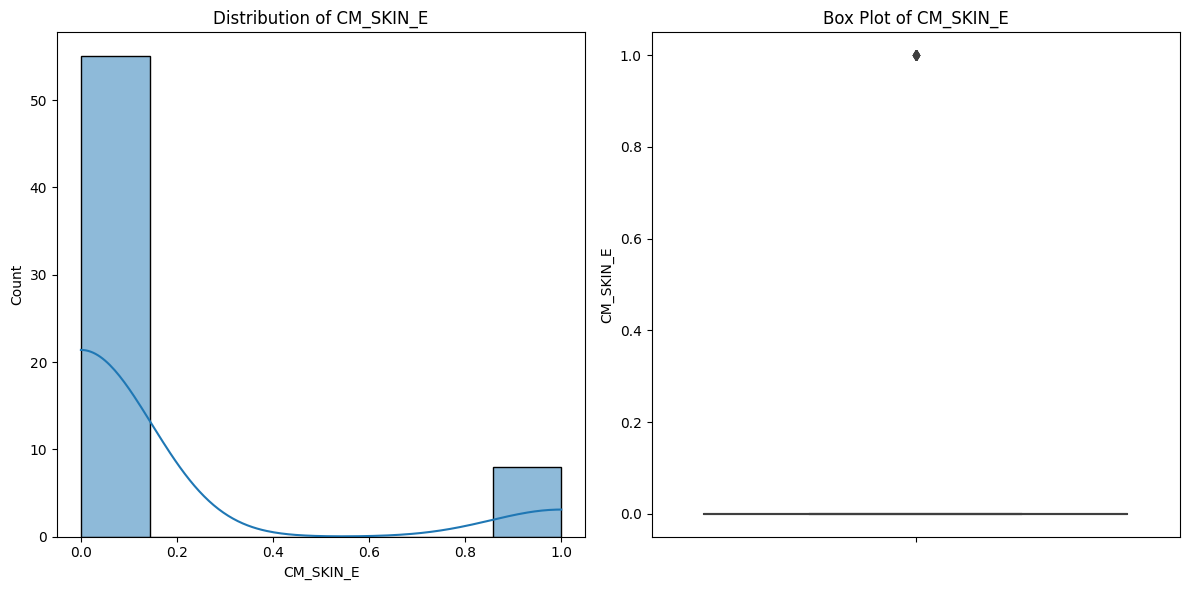


Statistics for CM_SKIN_E:
Count: 63
Missing: 501
Mean: 0.13
Median: 0.00
Std: 0.34
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


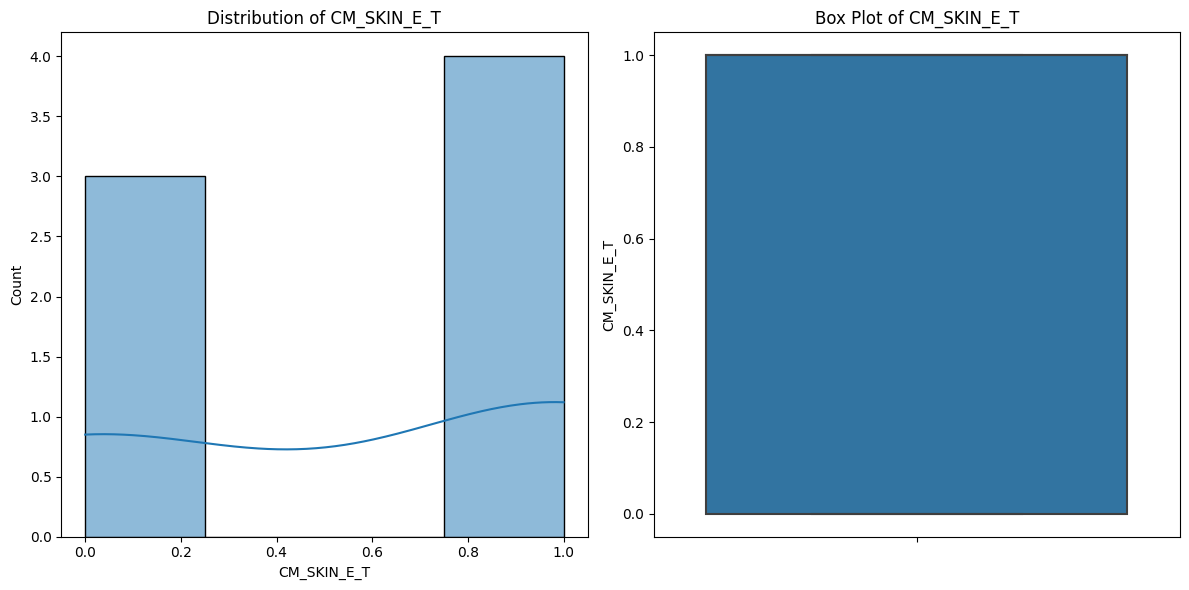


Statistics for CM_SKIN_E_T:
Count: 7
Missing: 557
Mean: 0.57
Median: 1.00
Std: 0.53
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


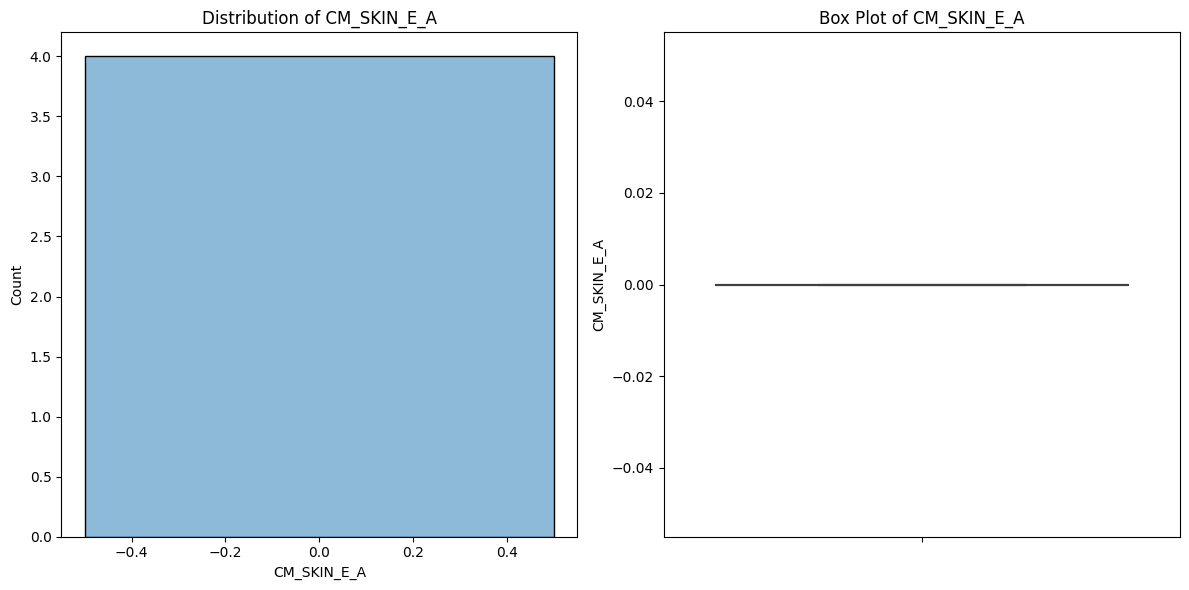


Statistics for CM_SKIN_E_A:
Count: 4
Missing: 560
Mean: 0.00
Median: 0.00
Std: 0.00
Min: 0.00
Max: 0.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


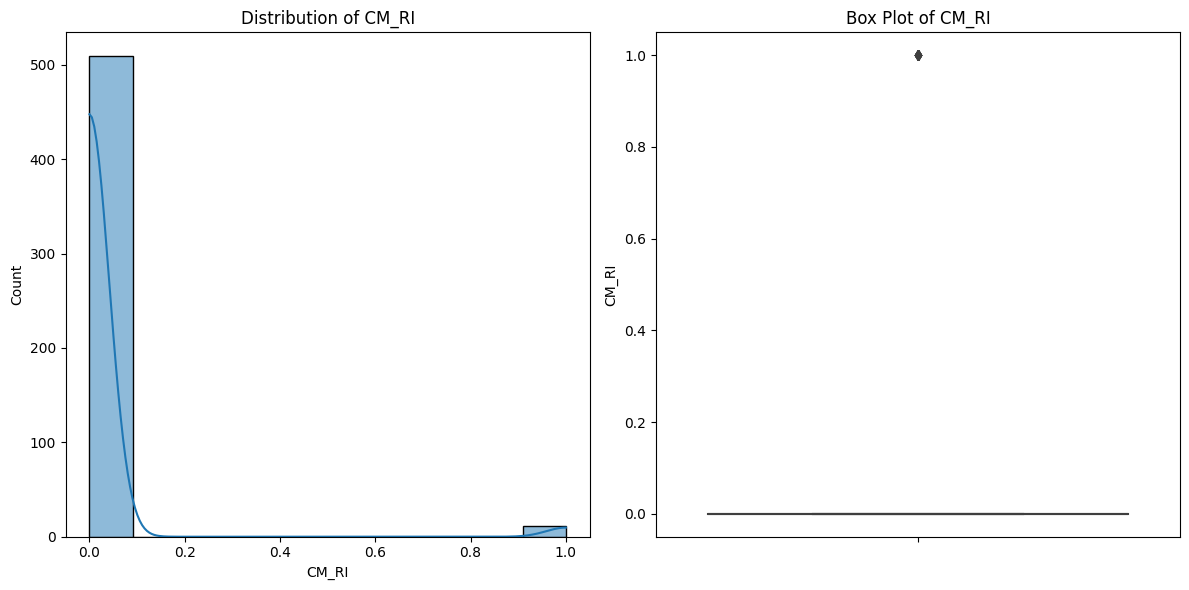


Statistics for CM_RI:
Count: 520
Missing: 44
Mean: 0.02
Median: 0.00
Std: 0.14
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


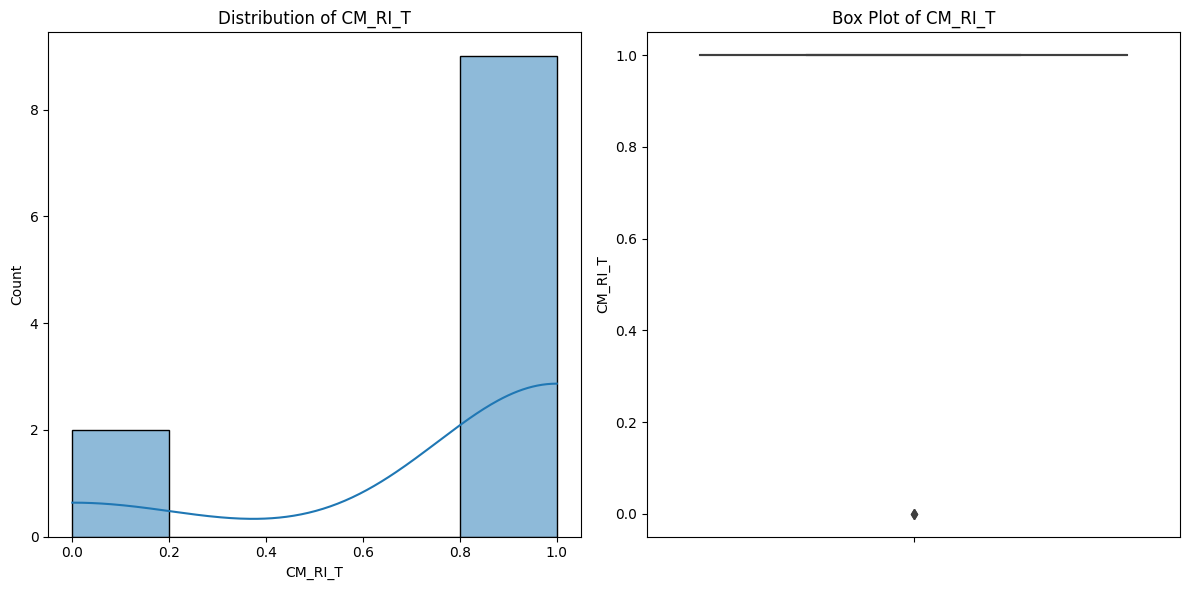


Statistics for CM_RI_T:
Count: 11
Missing: 553
Mean: 0.82
Median: 1.00
Std: 0.40
Min: 0.00
Max: 1.00


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


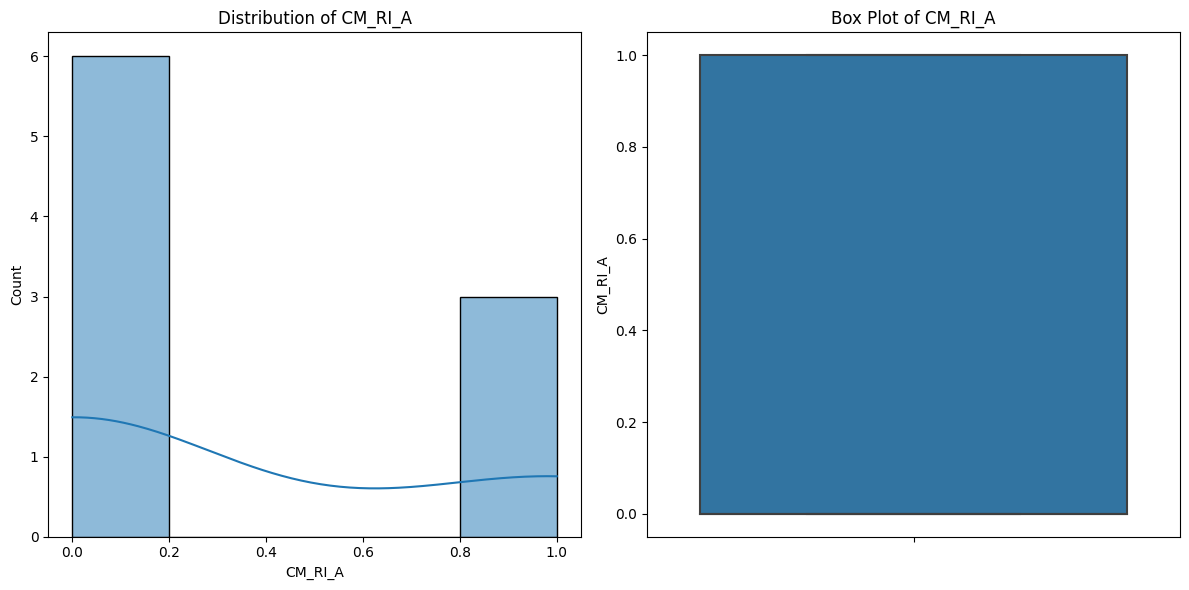

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_categorical_variables(df):
    """Analyze categorical variables with improved error handling"""
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        if df[col].dropna().empty:
            print(f"Skipping {col} - No non-null values")
            continue
            
        # Value counts and percentages
        value_counts = df[col].value_counts()
        value_percentages = df[col].value_counts(normalize=True) * 100
        
        # Only create visualization if there are values to plot
        if len(value_counts) > 0:
            plt.figure(figsize=(12, 6))
            
            # Create bar plot with explicit values
            ax = plt.subplot(1, 1, 1)
            bars = ax.bar(range(len(value_counts)), value_counts.values)
            
            # Customize the plot
            plt.title(f'Distribution of {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            
            # Add value labels on top of bars
            for i, bar in enumerate(bars):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:,}\n({value_percentages[i]:.1f}%)',
                       ha='center', va='bottom')
            
            # Set x-axis labels
            plt.xticks(range(len(value_counts)), value_counts.index, 
                      rotation=45, ha='right')
            
            plt.tight_layout()
            #plt.savefig(f'icc_analysis/{col}_distribution.png')
            plt.show()
        
        # Print summary statistics
        print(f"\nAnalysis for {col}:")
        print(f"Missing values: {df[col].isnull().sum()} ({df[col].isnull().mean()*100:.2f}%)")
        print(f"Number of unique values: {df[col].nunique()}")
        print("\nValue counts:")
        for val, count, pct in zip(value_counts.index, value_counts, value_percentages):
            print(f"{val}: {count} ({pct:.2f}%)")

def analyze_numeric_variables(df):
    """Analyze numeric variables with improved error handling"""
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    for col in numeric_cols:
        if df[col].dropna().empty:
            print(f"Skipping {col} - No non-null values")
            continue
            
        plt.figure(figsize=(12, 6))
        
        # Distribution plot
        plt.subplot(1, 2, 1)
        sns.histplot(data=df, x=col, kde=True)
        plt.title(f'Distribution of {col}')
        
        # Box plot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col].dropna())
        plt.title(f'Box Plot of {col}')
        
        plt.tight_layout()
        #plt.savefig(f'icc_analysis/{col}_distribution.png')
        plt.show()
        
        # Calculate statistics
        stats_dict = {
            'Count': df[col].count(),
            'Missing': df[col].isnull().sum(),
            'Mean': df[col].mean(),
            'Median': df[col].median(),
            'Std': df[col].std(),
            'Min': df[col].min(),
            'Max': df[col].max()
        }
        
        print(f"\nStatistics for {col}:")
        for stat, value in stats_dict.items():
            print(f"{stat}: {value:.2f}" if isinstance(value, float) else f"{stat}: {value}")

def analyze_data(df):
    """Main analysis function"""
    
    
    print("Starting analysis...")
    print("\nAnalyzing numeric variables...")
    analyze_numeric_variables(df)
    
    print("\nAnalyzing categorical variables...")
    analyze_categorical_variables(df)
    
    print("\nAnalysis complete. Results saved in 'icc_analysis' directory.")

# Run the analysis
analyze_data(icc_clean)